### Model 3: DeBERTa-v3 Sentiment Model - **Overview**

- **What this model is:** A fine-tuned Transformer (`microsoft/deberta-v3-base`) that predicts **Negative / Neutral / Positive** from review text.
- **Why we built it:** We needed a stronger sentiment model for our review aggregator that can generalise to **new products** and support our dashboards (AI vs Human rating + summaries).

- **What the model sees (inputs):**  
  - **Only** the review writing: **title + body** → `text_model`  
  - No product id, no rating, no extra metadata as features.

- **What the model learns to predict (labels):**  
  - Labels come **only from the human star rating** (our available ground truth):
    - 1–2 stars → **Negative**
    - 3 stars → **Neutral**
    - 4–5 stars → **Positive**

- **How we avoid “cheating” (data leakage control):**  
  - We use **ASIN** as `item_id` and do a **group-aware split**  
  - Meaning: the same product’s reviews can’t appear in both train and test.

- **Cleaning rules:**  
  - Remove empty/too-short review text  
  - Keep only valid ratings (1–5)  
  - Drop exact duplicates (`item_id + text_model + label`)

- **Training setup (what makes ours different):**  
  - We use **Focal Loss** + mild class weights to handle imbalance and focus on harder examples:
    - `GAMMA = 2.0`
    - `alpha` weights from label counts (inverse-sqrt, mean-normalised)
  - We choose the best checkpoint using **Macro F1** (not just accuracy)  
  - Early stopping is enabled to prevent overfitting.

- **Outputs we save for the app:**  
  - Trained model + tokenizer  
  - Label maps + evaluation metrics  
  - Predictions/probabilities for analysis dashboards

- **Important note:**  
  - The notebook may also include an extra **inference-only** sentiment pipeline for comparison work.  
  - That part is separate and does **not** train Model 3.



---



## **Install dependencies**

In [1]:
# STEP: Pin versions + wipe old checkpoints (run once), then RESTART runtime (important)

!pip -q install -U \
  "transformers==4.44.2" \
  "datasets==2.20.0" \
  "evaluate==0.4.2" \
  "accelerate==0.33.0" \
  "safetensors>=0.4.3"

import glob
import os
import shutil

# wipe any previous corrupted training dirs so it works in in Colab.
for pat in ["./teacher_deberta*", "./artifacts_teacher*", "./student_distilroberta*"]:
    for d in glob.glob(pat):
        shutil.rmtree(d, ignore_errors=True)



Done. NOW go to Runtime -> Restart runtime, then run notebook from the top again.


**Important** Restart runtime now then continue....

In [1]:
!pip -q install -U transformers datasets accelerate evaluate scikit-learn sentencepiece
!pip -q install -U optimum onnxruntime onnxruntime-tools

## **Imports**, reproducibility, environment check

In [2]:
import json
import os
import platform
import random
from pathlib import Path

import datasets
import evaluate
import numpy as np
import pandas as pd
import torch
import transformers

SEED = 42

# Repoducibility

def seed_everything(seed: int = 42) -> None:
    """Seed Python, NumPy, and PyTorch for reproducible runs."""
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Deterministic behavior (slower, but reproducible)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(SEED)

# Environments

print("Python:", platform.python_version())
print("Torch:", torch.__version__)
print("Transformers:", transformers.__version__)
print("Datasets:", datasets.__version__)
print("Evaluate:", evaluate.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
    print("BF16 supported:", torch.cuda.is_bf16_supported())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Python: 3.12.12
Torch: 2.10.0+cu128
Transformers: 5.2.0
Datasets: 4.5.0
Evaluate: 0.4.6
CUDA available: True
GPU: Tesla T4
BF16 supported: True
Device: cuda


## 2) **Load** `user_reviews.csv`



---


 Datasets 1429_1  **+**

 Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products : **+**

Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19    
   = **user_reviews.csv**


---



In [4]:
from pathlib import Path

# Add/remove paths as needed. The notebook will use the first one that exists.
CANDIDATE_PATHS = [
    Path("user_reviews.csv"),
    Path("user_reviews.csv"),
]

CSV_PATH = None
for p in CANDIDATE_PATHS:
    if p.exists():
        CSV_PATH = str(p)
        break

if CSV_PATH is None:
    raise FileNotFoundError(f"Could not find user_reviews.csv in: {CANDIDATE_PATHS}")

df = pd.read_csv(CSV_PATH, engine='python', on_bad_lines='warn')

print("Loaded:", CSV_PATH)
print("df.shape:", df.shape)
print("Columns:", list(df.columns))

/tmp/ipython-input-1922138263.py:18: ParserWarning: Skipping line 53532: unexpected end of data

  df = pd.read_csv(CSV_PATH, engine='python', on_bad_lines='warn')


Loaded: user_reviews.csv
df.shape: (53530, 28)
Columns: ['id', 'name', 'asins', 'brand', 'categories', 'keys', 'manufacturer', 'reviews.date', 'reviews.dateAdded', 'reviews.dateSeen', 'reviews.didPurchase', 'reviews.doRecommend', 'reviews.id', 'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs', 'reviews.text', 'reviews.title', 'reviews.userCity', 'reviews.userProvince', 'reviews.username', 'source_file', 'dateAdded', 'dateUpdated', 'primaryCategories', 'imageURLs', 'manufacturerNumber', 'sourceURLs']


#**Preprocessing**

## Rules:

* I only feed the model the actual written review (title + body). Nothing else.

* The sentiment label comes only from the star rating, not from the text.

* I use the product’s ASIN as the group id (first ASIN if there are multiple) so the same product can’t appear in both train and test.

* I remove empty/too-short reviews and exact duplicates to keep evaluation honest.


In [13]:
import re

# ---- Column names in this dataset ----
COL_TITLE   = "reviews.title"
COL_BODY    = "reviews.text"
COL_RATING  = "reviews.rating"
COL_REVID   = "reviews.id" if "reviews.id" in df.columns else "id"
COL_GROUP   = "asins"  # product identifier (may contain multiple ASINs separated by commas)

# ---- Safe text cleaning: keep casing/punctuation, just normalize whitespace ----
def clean_text(x):
    if pd.isna(x):
        return ""
    x = str(x).strip()
    x = re.sub(r"\s+", " ", x)
    return x

df["title_clean"] = df[COL_TITLE].apply(clean_text) if COL_TITLE in df.columns else ""
df["body_clean"]  = df[COL_BODY].apply(clean_text) if COL_BODY in df.columns else ""

# Combine title + body (often boosts neutral/negative detection)
df["text_model"] = (df["title_clean"] + ". " + df["body_clean"]).str.strip()
df["text_model"] = df["text_model"].str.replace(r"^\.\s*", "", regex=True)

# Product/item id: take first ASIN when multiple are present
df["item_id"] = df[COL_GROUP].astype(str).fillna("").str.split(",").str[0].str.strip()

# Drop empty text and missing item_id
df = df[df["text_model"].str.len() >= 5].copy()
df = df[df["item_id"].str.len() > 0].copy()

# Rating -> label: 1-2 neg, 3 neutral, 4-5 pos
df["rating"] = pd.to_numeric(df[COL_RATING], errors="coerce")
df = df[df["rating"].between(1, 5)].copy()

def rating_to_label(r):
    if r <= 2: return 0  # negative
    if r == 3: return 1  # neutral
    return 2             # positive

df["label"] = df["rating"].apply(rating_to_label).astype(int)

id2label = {0: "negative", 1: "neutral", 2: "positive"}
label2id = {v: k for k, v in id2label.items()}

# Optional: remove exact duplicates (text+label+item_id)
df = df.drop_duplicates(subset=["item_id", "text_model", "label"]).copy()

print("After preprocessing:", df.shape)
print("Label distribution:")
display(df["label"].map(id2label).value_counts())
display((df["label"].map(id2label).value_counts(normalize=True) * 100).round(2))

After preprocessing: (47416, 34)
Label distribution:


,count
label,
positive,43455
neutral,2092
negative,1869


,proportion
label,
positive,91.65
neutral,4.41
negative,3.94


 ## **Why we do it this way**

We need supervised labels to train a sentiment model, and the dataset doesn’t contain hand-labelled sentiment.

Star ratings are the best available proxy, so we convert ratings into 3 sentiment classes (neg/neutral/pos).

The model never sees the rating as input (**it only sees the review text**) so it learns language patterns that typically match how humans rate.

After training, the model can judge sentiment from text alone, and we can compare AI vs human ratings to spot agreement and mismatch.



---



## **Train/Test split (80/20)**
We ensure **no product (item_id)** appears in both train and test.


In [6]:
import numpy as np

X = df["text_model"].values
y = df["label"].values
groups = df["item_id"].values

# Prefer group-aware split (no product leakage) but fall back safely if needed.
try:
    from sklearn.model_selection import StratifiedGroupKFold
    if pd.Series(groups).nunique() < 2:
        raise ValueError("Only one unique group found; cannot do group-aware split.")
    sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=SEED)  # 5 folds ≈ 80/20
    train_idx, test_idx = next(sgkf.split(X, y, groups=groups))
except Exception as e:
    print("Falling back to stratified row-level split (group split unavailable):", repr(e))
    from sklearn.model_selection import StratifiedShuffleSplit
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
    train_idx, test_idx = next(sss.split(X, y))

train_df = df.iloc[train_idx].copy()
test_df  = df.iloc[test_idx].copy()

# sanity checks
overlap = set(train_df["item_id"]).intersection(set(test_df["item_id"]))
print("Train rows:", len(train_df), "Test rows:", len(test_df))
print("Group overlap (0 expected for group-aware split):", len(overlap))

print("\nTrain label dist (%):")
display((train_df["label"].map(id2label).value_counts(normalize=True) * 100).round(2))
print("Test label dist (%):")
display((test_df["label"].map(id2label).value_counts(normalize=True) * 100).round(2))


Train rows: 36450 Test rows: 10966
Group overlap (0 expected for group-aware split): 0

Train label dist (%):


,proportion
label,
positive,91.94
negative,4.23
neutral,3.83


Test label dist (%):


,proportion
label,
positive,90.66
neutral,6.35
negative,2.99


### Hugging Face + Tokenization (DeBERTa Teacher)

In this section we load our pretrained DeBERTa-v3 model from **Hugging Face** and prepare the review text so the model can understand it. “Tokenization” simply means converting our `text_model` (title + body) into the model’s input format: token IDs and an attention mask. We also set up the model as a **3-class classifier** (negative / neutral / positive), so during training it learns to map real review language to our sentiment labels.

In [7]:
from datasets import Dataset
from transformers import AutoTokenizer, DataCollatorWithPadding

TEACHER_MODEL = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(TEACHER_MODEL)

train_ds = Dataset.from_pandas(train_df[["item_id", "text_model", "label", COL_REVID]], preserve_index=False)
test_ds  = Dataset.from_pandas(test_df[["item_id", "text_model", "label", COL_REVID]], preserve_index=False)

MAX_LEN = 256

def tok_teacher(batch):
    return tokenizer(batch["text_model"], truncation=True, max_length=MAX_LEN)

train_ds = train_ds.map(tok_teacher, batched=True, remove_columns=[])
test_ds  = test_ds.map(tok_teacher,  batched=True, remove_columns=[])

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Trainer expects 'labels' key; map label -> labels
train_ds = train_ds.rename_column("label", "labels")
test_ds  = test_ds.rename_column("label", "labels")

train_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_ds.set_format(type="torch",  columns=["input_ids", "attention_mask", "labels"])

print(train_ds)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

Map:   0%|          | 0/36450 [00:00<?, ? examples/s]

Map:   0%|          | 0/10966 [00:00<?, ? examples/s]

Dataset({
    features: ['item_id', 'text_model', 'labels', 'reviews.id', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 36450
})


### Why DeBERTa Teacher?

We use DeBERTa-v3 as our “teacher” because it’s a strong general-purpose language model that usually performs very well on noisy, real-world text like product reviews. It gives us a high-quality starting point, so we don’t train from scratch, we just fine-tune it on our dataset to match how people express sentiment in reviews. So basicly: better language understanding, better generalisation, and faster results than classic baselines.

 ##  **Create Teacher**

In [8]:
# Cell: (Re)create teacher + tokenizer for fune tuning our text sentiment.

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding

# assumes you already have: device, id2label, label2id, train_ds/test_ds with input_ids/attention_mask/labels
TEACHER_MODEL = "microsoft/deberta-v3-base"

# tokenizer (teacher)
tokenizer = AutoTokenizer.from_pretrained(TEACHER_MODEL, use_fast=False)

# collator (pads dynamically)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# model (teacher)
teacher = AutoModelForSequenceClassification.from_pretrained(
    TEACHER_MODEL,
    num_labels=3,
    id2label=id2label,
    label2id=label2id,
)

teacher.to(device)
print("teacher created on:", device)
print("teacher num_labels:", teacher.config.num_labels)


pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2ForSequenceClassification LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     | 
----------------------------------------+------------+-
lm_predictions.lm_head.bias             | UNEXPECTED | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED | 
mask_predictions.classifier.bias        | UNEXPECTED | 
mask_predictions.LayerNorm.bias         | UNEXPECTED | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED | 
mask_predictions.LayerNorm.weight       | UNEXPECTED | 
mask_predictions.dense.weight           | UNEXPECTED | 
mask_predictions.dense.bias             | UNEXPECTED | 
mask_predictions.classifier.weight      | UNEXPECTED | 
pooler.dense.weight                     | MISSING    | 
pooler.dense.bias                       | MISSING    | 
classifier.bias                         | MISSING    | 
classifier.weight        

teacher created on: cuda
teacher num_labels: 3


 ## **CPU Check (stability test):**  
Before we train on the GPU, we rebuild a fresh DeBERTa “teacher” on the CPU and run a quick forward pass + one training step on a real batch. This helps us confirm the model, data, and loss are behaving normally (no NaNs/Infs) before we spend time debugging GPU issues.

In [9]:
# CPU Check

import gc

import numpy as np
import torch
from transformers import AutoModelForSequenceClassification

def any_nan_params(m):
    bad = []
    for n, p in m.named_parameters():
        if p is not None and torch.isnan(p.detach()).any():
            bad.append(n)
            if len(bad) >= 5:
                break
    return bad

# ---- 0) Clear memory + reset CUDA state ----
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()

# ---- 1) Recreate a *fresh* teacher from HF ----
TEACHER_MODEL = "microsoft/deberta-v3-base"
teacher_cpu = AutoModelForSequenceClassification.from_pretrained(
    TEACHER_MODEL, num_labels=3, id2label=id2label, label2id=label2id
).float().to("cpu")
teacher_cpu.train()

print("Teacher recreated. dtype:", next(teacher_cpu.parameters()).dtype, "| device:", next(teacher_cpu.parameters()).device)

# Check parameters for NaNs right after load
bad_params = any_nan_params(teacher_cpu)
print("NaN params right after load (first 5):", bad_params if bad_params else "None ✅")

# ---- 2) Grab ONE batch exactly as Trainer would see it ----
from torch.utils.data import DataLoader
dl = DataLoader(train_ds, batch_size=8, shuffle=True, collate_fn=data_collator)
batch = next(iter(dl))
batch_cpu = {k: v.to("cpu") for k, v in batch.items() if k in ["input_ids", "attention_mask", "labels"]}

print("Batch label uniques:", torch.unique(batch_cpu["labels"]).tolist())
print("input_ids min/max:", int(batch_cpu["input_ids"].min()), int(batch_cpu["input_ids"].max()))

# ---- 3) CPU forward check ----
with torch.no_grad():
    out = teacher_cpu(input_ids=batch_cpu["input_ids"], attention_mask=batch_cpu["attention_mask"])
    logits = out.logits

print("CPU forward logits finite?", torch.isfinite(logits).all().item(),
      "| any NaN?", torch.isnan(logits).any().item(),
      "| min/max:", float(logits.min()), float(logits.max()))

# ---- 4) CPU one training step ----
opt = torch.optim.AdamW(teacher_cpu.parameters(), lr=1e-6, weight_decay=0.0, eps=1e-8)
loss_fn = torch.nn.CrossEntropyLoss()

out = teacher_cpu(input_ids=batch_cpu["input_ids"], attention_mask=batch_cpu["attention_mask"])
logits = out.logits
loss = loss_fn(logits.float(), batch_cpu["labels"].long())

print("CPU loss finite?", torch.isfinite(loss).item(), "| loss:", float(loss))

opt.zero_grad()
loss.backward()
torch.nn.utils.clip_grad_norm_(teacher_cpu.parameters(), 0.1)
opt.step()

with torch.no_grad():
    logits2 = teacher_cpu(input_ids=batch_cpu["input_ids"], attention_mask=batch_cpu["attention_mask"]).logits

print("CPU post-step logits finite?", torch.isfinite(logits2).all().item(),
      "| any NaN?", torch.isnan(logits2).any().item(),
      "| min/max:", float(logits2.min()), float(logits2.max()))


Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2ForSequenceClassification LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     | 
----------------------------------------+------------+-
lm_predictions.lm_head.bias             | UNEXPECTED | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED | 
mask_predictions.classifier.bias        | UNEXPECTED | 
mask_predictions.LayerNorm.bias         | UNEXPECTED | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED | 
mask_predictions.LayerNorm.weight       | UNEXPECTED | 
mask_predictions.dense.weight           | UNEXPECTED | 
mask_predictions.dense.bias             | UNEXPECTED | 
mask_predictions.classifier.weight      | UNEXPECTED | 
pooler.dense.weight                     | MISSING    | 
pooler.dense.bias                       | MISSING    | 
classifier.bias                         | MISSING    | 
classifier.weight        

Teacher recreated. dtype: torch.float32 | device: cpu
NaN params right after load (first 5): None ✅
Batch label uniques: [2]
input_ids min/max: 0 73871
CPU forward logits finite? True | any NaN? False | min/max: -0.2832764983177185 0.5136434435844421


/tmp/ipython-input-3526489560.py:63: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  print("CPU loss finite?", torch.isfinite(loss).item(), "| loss:", float(loss))


CPU loss finite? True | loss: 1.3238649368286133
CPU post-step logits finite? True | any NaN? False | min/max: -0.12164048105478287 0.5673280954360962


**Why are we hardware-optimising / checking this?**  
GPU training can fail for reasons that look “random” (memory spikes, mixed precision, unstable gradients). This CPU sanity check tells us whether the problem is the **data/model setup** or the **hardware/training environment**, so we can fix the right thing faster.



---



## **GPU 1-Step Diagnostic**  
Here we run the exact same “single batch” check on the GPU: load the DeBERTa teacher, do one forward pass, compute a loss, and take one optimizer step. If logits or loss turn into NaN/Inf at this point, it’s a strong sign something in the GPU training setup (device, memory, precision, gradients) is unstable.


In [10]:
# GPU 1-STEP DIAGNOSTIC (after stability switches)

import torch
from transformers import AutoModelForSequenceClassification
from torch.utils.data import DataLoader

TEACHER_MODEL = "microsoft/deberta-v3-base"
teacher = AutoModelForSequenceClassification.from_pretrained(
    TEACHER_MODEL, num_labels=3, id2label=id2label, label2id=label2id
).float().to(device)

teacher.train()

dl = DataLoader(train_ds, batch_size=8, shuffle=True, collate_fn=data_collator)
batch = next(iter(dl))
batch = {k: v.to(device) for k, v in batch.items() if k in ["input_ids","attention_mask","labels"]}

# forward
out = teacher(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
logits = out.logits
print("GPU forward logits finite?", torch.isfinite(logits).all().item(),
      "| any NaN?", torch.isnan(logits).any().item(),
      "| min/max:", float(logits.min()), float(logits.max()))

# one step
opt = torch.optim.AdamW(teacher.parameters(), lr=1e-6, weight_decay=0.0, eps=1e-8)
loss_fn = torch.nn.CrossEntropyLoss()

loss = loss_fn(logits.float(), batch["labels"].long())
print("GPU loss finite?", torch.isfinite(loss).item(), "| loss:", float(loss))

opt.zero_grad()
loss.backward()
torch.nn.utils.clip_grad_norm_(teacher.parameters(), 0.1)
opt.step()

with torch.no_grad():
    logits2 = teacher(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]).logits

print("GPU post-step logits finite?", torch.isfinite(logits2).all().item(),
      "| any NaN?", torch.isnan(logits2).any().item(),
      "| min/max:", float(logits2.min()), float(logits2.max()))


Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2ForSequenceClassification LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     | 
----------------------------------------+------------+-
lm_predictions.lm_head.bias             | UNEXPECTED | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED | 
mask_predictions.classifier.bias        | UNEXPECTED | 
mask_predictions.LayerNorm.bias         | UNEXPECTED | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED | 
mask_predictions.LayerNorm.weight       | UNEXPECTED | 
mask_predictions.dense.weight           | UNEXPECTED | 
mask_predictions.dense.bias             | UNEXPECTED | 
mask_predictions.classifier.weight      | UNEXPECTED | 
pooler.dense.weight                     | MISSING    | 
pooler.dense.bias                       | MISSING    | 
classifier.bias                         | MISSING    | 
classifier.weight        

GPU forward logits finite? True | any NaN? False | min/max: -0.4931591749191284 0.17987306416034698
GPU loss finite? True | loss: 1.163209080696106
GPU post-step logits finite? True | any NaN? False | min/max: -0.28442150354385376 0.2521018981933594


**Why do this on the GPU as well?**  
CPU can look fine, but GPU training can still break due to CUDA/memory/precision behaviour. This tiny one-step test confirms the model can safely train on the GPU *before* we launch the full Trainer loop.

**Note**: Colab A100 or higher GPU is reconmended for this model. **lower may generate stability issues in training and take longer**



---



## **Training the DeBERTa “teacher” (with Focal Loss):**  
This is the main fine-tuning step. We train the DeBERTa model on our review text to predict **negative / neutral / positive**, using **Focal Loss** plus mild class weights to handle imbalance and focus more on harder examples (especially neutral/negative). We evaluate each epoch and keep the best checkpoint based on **macro F1**, with early stopping to avoid overfitting.

In [12]:
# TRAIN TEACHER WITH FOCAL LOSS
# Logic unchanged — refactor is for readability + lint-friendliness.

from typing import Dict, Tuple

import numpy as np
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments

# Mild alpha weights (NOT extreme): inverse-sqrt, mean-normalized
counts = train_df["label"].value_counts().sort_index()
alpha = np.sqrt(counts.sum() / (counts + 1e-9)).values
alpha = (alpha / alpha.mean()).astype(np.float32)
alpha_t = torch.tensor(alpha, dtype=torch.float32, device=device)

print("Train label counts:", counts.to_dict())
print("Alpha (focal):", alpha_t.detach().cpu().tolist())

GAMMA = 2.0  # focal strength; typical range 1.5–3.0


def compute_metrics(eval_pred: Tuple[np.ndarray, np.ndarray]) -> Dict[str, float]:
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": float(accuracy_score(labels, preds)),
        "f1_macro": float(f1_score(labels, preds, average="macro")),
    }


class FocalLossTrainer(Trainer):
    """Trainer override to use focal loss (alpha-balanced)."""

    def compute_loss(  # type: ignore[override]
        self,
        model,
        inputs,
        return_outputs: bool = False,
        num_items_in_batch: int = 0,  # HF signature compatibility
    ):
        labels = inputs["labels"].long()
        outputs = model(input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"])
        logits = outputs.logits

        # Guards
        if torch.isnan(logits).any() or torch.isinf(logits).any():
            raise RuntimeError("Logits contain NaN/Inf during training.")

        # log-probs
        logp = F.log_softmax(logits.float(), dim=-1)
        p = logp.exp()

        # gather probs for true class
        idx = labels.view(-1, 1)
        logp_t = logp.gather(1, idx).squeeze(1)
        p_t = p.gather(1, idx).squeeze(1)

        # alpha per sample
        alpha_s = alpha_t.gather(0, labels)

        # focal loss
        loss = -alpha_s * ((1 - p_t) ** GAMMA) * logp_t
        loss = loss.mean()

        if torch.isnan(loss) or torch.isinf(loss):
            raise RuntimeError("Loss became NaN/Inf during training.")

        return (loss, outputs) if return_outputs else loss


args = TrainingArguments(
    output_dir="./teacher_deberta_focal",
    learning_rate=1e-6,  # keep stable; can raise after it works
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.0,
    warmup_steps=500,
    lr_scheduler_type="linear",
    max_grad_norm=0.1,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    logging_steps=100,
    fp16=False,
    bf16=False,
    seed=SEED,
    report_to="none",
    save_total_limit=2,
)

trainer = FocalLossTrainer(
    model=teacher,  # re-use your current teacher object
    args=args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)],
)

trainer.train()


Train label counts: {0: 1541, 1: 1396, 2: 33513}
Alpha (focal): [1.3244531154632568, 1.391538381576538, 0.2840084433555603]


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.090945,0.123473,0.906073,0.516970
2,0.088608,0.164028,0.915010,0.513144


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['deberta.embeddings.LayerNorm.weight', 'deberta.embeddings.LayerNorm.bias', 'deberta.encoder.layer.0.attention.output.LayerNorm.weight', 'deberta.encoder.layer.0.attention.output.LayerNorm.bias', 'deberta.encoder.layer.0.output.LayerNorm.weight', 'deberta.encoder.layer.0.output.LayerNorm.bias', 'deberta.encoder.layer.1.attention.output.LayerNorm.weight', 'deberta.encoder.layer.1.attention.output.LayerNorm.bias', 'deberta.encoder.layer.1.output.LayerNorm.weight', 'deberta.encoder.layer.1.output.LayerNorm.bias', 'deberta.encoder.layer.2.attention.output.LayerNorm.weight', 'deberta.encoder.layer.2.attention.output.LayerNorm.bias', 'deberta.encoder.layer.2.output.LayerNorm.weight', 'deberta.encoder.layer.2.output.LayerNorm.bias', 'deberta.encoder.layer.3.attention.output.LayerNorm.weight', 'deberta.encoder.layer.3.attention.output.LayerNorm.bias', 'deberta.encoder.layer.3.output.LayerNorm.weight', 'deberta.encoder.layer.3.output.Laye

TrainOutput(global_step=4558, training_loss=0.10285429496313198, metrics={'train_runtime': 2788.5162, 'train_samples_per_second': 39.214, 'train_steps_per_second': 2.452, 'total_flos': 4732019344100880.0, 'train_loss': 0.10285429496313198, 'epoch': 2.0})

**Why Focal Loss here?**  
Review sentiment is usually skewed toward positive ratings, so standard loss can “play it safe” and ignore minority classes. Focal Loss reduces the influence of easy majority examples and pushes the model to learn the harder cases that matter most in a review aggregator.



---



## **Build the “scored” predictions table (test set):**  
After training, we run the model on the test set and calculate the key evaluation outputs (classification report + confusion matrix). We then build a single clean dataframe (`scored`) that combines the original test review info (text, ASIN/item_id, review id) with the model’s prediction, confidence score, and class probabilities — and export it to `scored_test_predictions.csv` for dashboards and analysis.

Logits any NaN? False | any Inf? False
len(test_ds): 10966 | len(test_df): 10966 | len(preds): 10966

Classification report:
              precision    recall  f1-score   support

    negative     0.4310    0.5427    0.4804       328
     neutral     0.2723    0.0747    0.1172       696
    positive     0.9370    0.9766    0.9564      9942

    accuracy                         0.9063     10966
   macro avg     0.5467    0.5313    0.5180     10966
weighted avg     0.8797    0.9063    0.8889     10966

Confusion matrix:
 [[ 178   30  120]
 [ 111   52  533]
 [ 124  109 9709]]


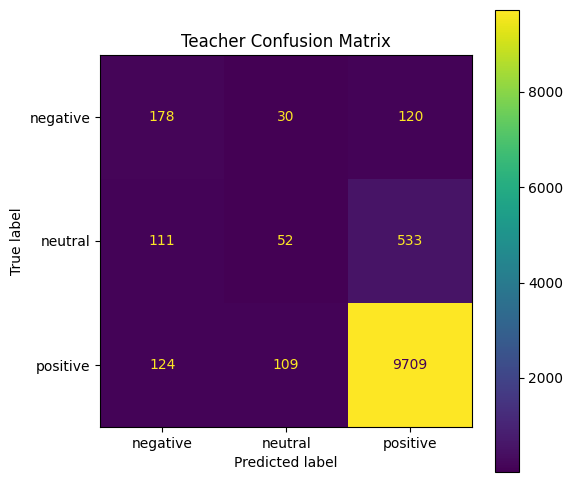


Saved per-review predictions to: /content/scored_test_predictions.csv

Scored sample (8 rows):


,reviews.id,item_id,true_label,pred_label,pred_conf,text_snippet
0,NaN,B018Y229OU,positive,positive,0.800723,"Good. Good basic tablet for checking email , w..."
1,NaN,B018Y229OU,positive,positive,0.843351,Great tablet!. I love this tablet. It was a gr...
2,NaN,B018Y229OU,positive,positive,0.810793,Good tablet for a low price.. Brought my old t...
3,NaN,B018Y229OU,positive,positive,0.760645,Good tablet for a beginner. Good Inexpensive t...
4,NaN,B018Y229OU,positive,positive,0.820035,Great for kids. I got this for my niece. I wou...
5,NaN,B018Y229OU,positive,positive,0.834274,Good for grade school. A great product for my ...
6,NaN,B018Y229OU,positive,positive,0.837700,Great tablet for all ages. Purchased for my to...
7,NaN,B018Y229OU,neutral,positive,0.484056,Lack usability. Buying this device I thought i...


In [14]:
# BUILD SCORED DF (robust) — uses test_df for item_id/text/review id
# Requires: trainer, test_ds, test_df, id2label

from pathlib import Path
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from IPython.display import display
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
)

# 1) Predict
pred = trainer.predict(test_ds)
logits = pred.predictions
y_true = pred.label_ids

print("Logits any NaN?", np.isnan(logits).any(), "| any Inf?", np.isinf(logits).any())

probs = torch.softmax(torch.tensor(logits), dim=-1).numpy()
y_pred = probs.argmax(axis=-1)
pred_conf = probs.max(axis=-1)

# 2) Sanity check alignment
print("len(test_ds):", len(test_ds), "| len(test_df):", len(test_df), "| len(preds):", len(y_pred))
assert len(test_df) == len(test_ds) == len(y_pred), "Row mismatch: test_df/test_ds/preds not aligned."

# 3) Metrics
labels_order = [0, 1, 2]
target_names = [id2label[i] for i in labels_order]

print("\nClassification report:")
print(
    classification_report(
        y_true,
        y_pred,
        labels=labels_order,
        target_names=target_names,
        digits=4,
        zero_division=0,
    )
)

cm = confusion_matrix(y_true, y_pred, labels=labels_order)
print("Confusion matrix:\n", cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, values_format="d")
plt.title("Teacher Confusion Matrix")
plt.show()

# 4) Build scored from test_df (source of truth for text/item)
scored = test_df.copy().reset_index(drop=True)

# Ensure we have text + item_id columns; if names differ, adapt here:
TEXT_COL = "text_model"
ITEM_COL = "item_id"

assert TEXT_COL in scored.columns, (
    f"Missing text column '{TEXT_COL}' in test_df. Found: {list(scored.columns)[:20]}..."
)
assert ITEM_COL in scored.columns, (
    f"Missing item_id column '{ITEM_COL}' in test_df. Found: {list(scored.columns)[:20]}..."
)

# Review id: use reviews.id if present, else create one
if "reviews.id" not in scored.columns:
    scored["reviews.id"] = np.arange(len(scored), dtype=int)

# Attach predictions
scored["true_label_id"] = y_true
scored["pred_label_id"] = y_pred
scored["true_label"] = scored["true_label_id"].map(id2label)
scored["pred_label"] = scored["pred_label_id"].map(id2label)
scored["pred_conf"] = pred_conf

# Assumes 3-class order [0, 1, 2] = [negative, neutral, positive]
scored["prob_negative"] = probs[:, 0]
scored["prob_neutral"] = probs[:, 1]
scored["prob_positive"] = probs[:, 2]


def snippet(x: Optional[object], n: int = 220) -> str:
    s = "" if x is None else str(x)
    s = s.replace("\n", " ").strip()
    return s[:n] + ("..." if len(s) > n else "")


scored["text_snippet"] = scored[TEXT_COL].apply(snippet)

# Write to current working directory (portable across Colab/local)
OUT_PATH = Path("scored_test_predictions.csv")
scored.to_csv(OUT_PATH, index=False)
print(f"\nSaved per-review predictions to: {OUT_PATH.resolve()}")

print("\nScored sample (8 rows):")
display(scored[["reviews.id", ITEM_COL, "true_label", "pred_label", "pred_conf", "text_snippet"]].head(8))


**Why do we create a scored CSV?**  
It gives us one “source of truth” file we can reuse everywhere (AI vs Human rating comparison, product summaries, error analysis) without rerunning the model each time, and it makes debugging much easier because we can inspect real reviews alongside predictions and confidence.



---



## **Top-5 most confident predictions (by class):**  
This cell pulls out the **highest-confidence** reviews the model predicted as **negative**, **neutral**, and **positive**. It’s a quick “reality check” to make sure the predictions look sensible when we read the actual text — and it also gives us clean examples we can use in slides or demos.

In [15]:
# TOP-5 MOST CONFIDENT PER *PREDICTED* CLASS (NEG/NEU/POS)

import pandas as pd
from IPython.display import display, Markdown

# widen display
pd.set_option("display.width", 2000)
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_colwidth", 800)

# longer snippet
TEXT_COL = "text_model"  # change only if needed
def snippet(x, n=800):
    x = "" if x is None else str(x)
    x = x.replace("\n", " ").strip()
    return x[:n] + ("..." if len(x) > n else "")

scored["text_snippet_long"] = scored[TEXT_COL].apply(lambda t: snippet(t, n=800))

# product name column (optional)
CANDIDATE_PRODUCT_NAME_COLS = ["product_title", "product_name", "title", "name", "reviews.title", "summary"]
PROD_NAME_COL = next((c for c in CANDIDATE_PRODUCT_NAME_COLS if c in scored.columns), None)

SHOW = ["item_id"]
if PROD_NAME_COL:
    SHOW.append(PROD_NAME_COL)
SHOW += ["true_label", "pred_label", "pred_conf", "text_snippet_long"]

def show_top(sentiment: str, n: int = 5):
    sub = scored[scored["pred_label"] == sentiment].sort_values("pred_conf", ascending=False)

    # bold header + extra space
    display(Markdown(f"**Top {n} most confident PREDICTED '{sentiment.upper()}' reviews:**"))
    if len(sub) == 0:
        display(Markdown("_None predicted._"))
    else:
        display(sub[SHOW].head(n))

    # spacing between tables
    display(Markdown("<br><br>"))

show_top("negative", 5)
show_top("neutral",  5)
show_top("positive", 5)


**Top 5 most confident PREDICTED 'NEGATIVE' reviews:**

,item_id,name,true_label,pred_label,pred_conf,text_snippet_long
4524,B018Y229OU,"Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta",negative,negative,0.651111,"Lasted 120 days...30 past warranty. Died after 120 days....30 days out of warranty. Some no name brand lasted us 3 years before this one. Figured we would get a ""name brand"" thinking that it will last longer. I won't be purchasing Kindle/Amazon products anymore."
6326,B018Y229OU,"Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta",negative,negative,0.634844,poor quality. No longer takes charge from manufacture charger or any other type of charger. Product did not last very long since had 7 months.
411,B018Y229OU,"Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta",negative,negative,0.628895,"So, So. Stopped working after only a year. Felt flimsy. Did like that I could upload Amazon books"
2234,B018Y229OU,"Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta",positive,negative,0.622810,"Can't beat the price. Works as any other kindle fire. Does have advertisements, but for $49, can't beat the price."
44,B018Y229OU,"Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta",negative,negative,0.622525,Crashed and burned. Slow to use because there are constant popups. Barely dropped it 2 feet to the ground and now it doesn't work. Highly unsatisfied.


<br><br>

**Top 5 most confident PREDICTED 'NEUTRAL' reviews:**

,item_id,name,true_label,pred_label,pred_conf,text_snippet_long
2315,B018Y229OU,"Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta",positive,neutral,0.457741,"For the price, unbeatable. This wasn't for me, but for a family member (I have a Kindle Fire HDX for self). They very much appreciate having this as a replacement for another tablet, seems to work better (less/no crashes, better battery) compared to the older one (not an amazon tablet). Side-loaded texture/next-issue as a way to get unlimited magazines (can access subscription on several devices) on this, and it works fine (usually, but once had to clear app data).This tablet is not as high-res as the HDX (so tiny text isn't as clear as it could be without zooming) but it's more than sharp enough for daily use, especially at this price range"
5984,B018Y229OU,"Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta",positive,neutral,0.439245,"Good for the price. Overall it is hard to say this is a good Tablet just looking at it in a vacuum. That being said when you take the price into consideration, it is hard to say it's not a good value. The screen isn't very bright so outdoor use is difficult ( I wanted to use it as a screen for my drone but its not ideal), and it's locked down by the Amazon Echo System. It does work and it doesnt hiccup or struggle too much and again for the value especialyl when I bought it for $33 its hard to argue. It can also be hacked to install the Play Store on it which makes it even more of a value."
4962,B018Y229OU,"Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta",positive,neutral,0.433067,"Great for the price.. Got two for my kids for Christmas they have been great so far they hold a charge and there not slow. I bought two off brand tablets last year of lesser quality and they didn't last very long, These have been worth every penny. The only negative is that you will have to eventually expand the memory"
1219,B018Y229OU,"Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta",neutral,neutral,0.432544,It's great for beginners.. I like the size of it and it's easy to operate. I didn't like that I had to keep trying to put the same information in more than once to more from one screen to another when putting in my card information. I need to have wifi to look at the stuff I downloaded and I don't like that. But for the cost it's ok.
5627,B018Y229OU,"Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta",neutral,neutral,0.431232,"Simple and easy to use. The product would be great if it was easier to find the setting icon and if amazon wouldn't charge you a $1 for downloading applications that are labeled ""free."" The one dollar is automatically charged by amazon but you can dispute it with your Credit Company."


<br><br>

**Top 5 most confident PREDICTED 'POSITIVE' reviews:**

,item_id,name,true_label,pred_label,pred_conf,text_snippet_long
334,B018Y229OU,"Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta",positive,positive,0.847415,Great tablet. Love this tablet I got for both my young girls. They love them use them for games and learning games which all seem to be free for the most part.
10241,B018Y229OU,"Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta",positive,positive,0.847310,Awesome Stocking Stuffers. We bought two of these for our kids and they both love them! Easy to set up and operate. They are a welcome improvement over them using their phones for all the apps and games they enjoy.
3219,B018Y229OU,"Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta",positive,positive,0.847253,"Perfect for the kids. I purchased this item for my children, 7 and 11 it has been a good durable easy to use set up and use item."
851,B018Y229OU,"Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta",positive,positive,0.847202,Good starter tablet for my son. My son enjoys being on his tablet and getting on all the apps he has. It keeps him entertained. He loves it!
4735,B018Y229OU,"Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta",positive,positive,0.847157,Great. Great for kids. I love that i can monitor my kids.


<br><br>

**Why look at the most confident examples?**  
If the model is confident but the text clearly doesn’t match the label, that’s a red flag (either noisy labels or a model mistake). If they look correct, it builds trust that the model has learned the right sentiment patterns. In this case for this model, although not perfect it proves to be a much more trustable model in comparison to the previous un supervised models. (TF-IDF + KNN, Sentence embeddings + GMM & LinearSVC)

## **TOP 5** : Each product

In [16]:
# TOP-5 PER SENTIMENT, EACH FROM A DIFFERENT PRODUCT (item_id)
from IPython.display import display, Markdown
import pandas as pd

pd.set_option("display.width", 2000)
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_colwidth", 800)

SHOW = ["item_id"]
if "name" in scored.columns:
    SHOW.append("name")
SHOW += ["true_label", "pred_label", "pred_conf", "text_snippet_long"]

def top_unique_products(sentiment: str, n: int = 5):
    sub = scored[scored["pred_label"] == sentiment].sort_values("pred_conf", ascending=False)

    # keep only the top row per item_id
    sub_unique = sub.drop_duplicates(subset=["item_id"], keep="first")

    display(Markdown(f"**Top {n} most confident PREDICTED '{sentiment.upper()}' reviews (unique products):**"))
    if len(sub_unique) == 0:
        display(Markdown("_None predicted._"))
    else:
        display(sub_unique[SHOW].head(n))

    display(Markdown("<br><br>"))

top_unique_products("negative", 5)
top_unique_products("neutral", 5)
top_unique_products("positive", 5)


**Top 5 most confident PREDICTED 'NEGATIVE' reviews (unique products):**

,item_id,name,true_label,pred_label,pred_conf,text_snippet_long
4524,B018Y229OU,"Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta",negative,negative,0.651111,"Lasted 120 days...30 past warranty. Died after 120 days....30 days out of warranty. Some no name brand lasted us 3 years before this one. Figured we would get a ""name brand"" thinking that it will last longer. I won't be purchasing Kindle/Amazon products anymore."


<br><br>

**Top 5 most confident PREDICTED 'NEUTRAL' reviews (unique products):**

,item_id,name,true_label,pred_label,pred_conf,text_snippet_long
2315,B018Y229OU,"Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta",positive,neutral,0.457741,"For the price, unbeatable. This wasn't for me, but for a family member (I have a Kindle Fire HDX for self). They very much appreciate having this as a replacement for another tablet, seems to work better (less/no crashes, better battery) compared to the older one (not an amazon tablet). Side-loaded texture/next-issue as a way to get unlimited magazines (can access subscription on several devices) on this, and it works fine (usually, but once had to clear app data).This tablet is not as high-res as the HDX (so tiny text isn't as clear as it could be without zooming) but it's more than sharp enough for daily use, especially at this price range"


<br><br>

**Top 5 most confident PREDICTED 'POSITIVE' reviews (unique products):**

,item_id,name,true_label,pred_label,pred_conf,text_snippet_long
334,B018Y229OU,"Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta",positive,positive,0.847415,Great tablet. Love this tablet I got for both my young girls. They love them use them for games and learning games which all seem to be free for the most part.


<br><br>

## **Product × Sentiment example grid (3×3):** - Catagory set up (Pre-Website)
This cell builds a small “human-friendly” table to sanity-check our model at the **product level**. We pick 3 high-review products, then for each product we show the most confident **negative**, **neutral**, and **positive** predicted reviews (including confidence and the true label) so we can quickly see how sentiment looks across the same item.

In [17]:
# 3 PRODUCTS × 3 SENTIMENTS GRID (each row = different item_id)
import numpy as np
import pandas as pd

def pick_best(pid, sentiment):
    sub = scored[(scored["item_id"] == pid) & (scored["pred_label"] == sentiment)].sort_values("pred_conf", ascending=False)
    if len(sub) == 0:
        return "—"
    r = sub.iloc[0]
    return f"p={r['pred_conf']:.2f} (true={r['true_label']}) {r['text_snippet_long']}"

# pick 3 products with lots of reviews (more likely to have all sentiments)
top_products = scored["item_id"].value_counts().head(50).index.tolist()

rows = []
for pid in top_products:
    rows.append({
        "item_id": pid,
        "name": scored.loc[scored["item_id"] == pid, "name"].iloc[0] if "name" in scored.columns else "",
        "negative_review": pick_best(pid, "negative"),
        "neutral_review": pick_best(pid, "neutral"),
        "positive_review": pick_best(pid, "positive"),
    })
    if len(rows) == 3:
        break

grid = pd.DataFrame(rows)
display(grid)


,item_id,name,negative_review,neutral_review,positive_review
0,B018Y229OU,"Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta","p=0.65 (true=negative) Lasted 120 days...30 past warranty. Died after 120 days....30 days out of warranty. Some no name brand lasted us 3 years before this one. Figured we would get a ""name brand"" thinking that it will last longer. I won't be purchasing Kindle/Amazon products anymore.","p=0.46 (true=positive) For the price, unbeatable. This wasn't for me, but for a family member (I have a Kindle Fire HDX for self). They very much appreciate having this as a replacement for another tablet, seems to work better (less/no crashes, better battery) compared to the older one (not an amazon tablet). Side-loaded texture/next-issue as a way to get unlimited magazines (can access subscription on several devices) on this, and it works fine (usually, but once had to clear app data).This tablet is not as high-res as the HDX (so tiny text isn't as clear as it could be without zooming) but it's more than sharp enough for daily use, especially at this price range",p=0.85 (true=positive) Great tablet. Love this tablet I got for both my young girls. They love them use them for games and learning games which all seem to be free for the most part.


**Why this grid is useful:**  
It helps us spot patterns like “this product gets mixed feedback” and also reveals if the model is consistently confusing one sentiment for another on the same product - which is exactly the kind of insight we want for category/product summaries later. Thankfully in this case, this was not the case.

Layout schema: (For clarity)

| (product)  | negative_review | neutral_review | positive_review |
|------------|-----------------|----------------|-----------------|
| product 1  | ✅              | ✅             | ✅              |
| product 2  | ✅              | ✅             | ✅              |
| product 3  | ✅              | ✅             | ✅              |




---



## **Product × Sentiment grid (with AI star rating vs user star rating):**  
This version of the grid adds a simple “AI star rating” for each review by converting the model’s sentiment probabilities into a **1–5 score** (weighted average: 1×negative, 3×neutral, 5×positive). For each of the same 3 products, we show the most confident negative/neutral/positive review, and next to the text we display **Model stars vs Actual user stars** plus the model confidence. This makes it easier to see where the AI agrees with humans and where it thinks differently.

In [18]:
import pandas as pd
import numpy as np

# Wider pandas display (helps in Colab tables)
pd.set_option("display.width", 3000)
pd.set_option("display.max_columns", 80)
pd.set_option("display.max_colwidth", 1200)

# Rebuild the text with a clear separator (you can change the separator string)
SEP = "  | User Review: "   # visual gap

# Calculate model_star_rating_ui for the scored DataFrame
scored["model_star_rating_ui"] = (
    1.0 * scored["prob_negative"] +
    3.0 * scored["prob_neutral"] +
    5.0 * scored["prob_positive"]
).round(1)

def pick_best_with_stars_gap(pid, sentiment):
    sub = scored[(scored["item_id"] == pid) & (scored["pred_label"] == sentiment)].sort_values("pred_conf", ascending=False)
    if len(sub) == 0:
        return "—"
    r = sub.iloc[0]

    model_stars = f"{r['model_star_rating_ui']:.1f}★"
    actual_stars = f"{r['reviews.rating']}★" if "reviews.rating" in scored.columns else "N/A"

    stats = f"Model={model_stars} | Actual={actual_stars} | p={r['pred_conf']:.2f} | true={r['true_label']}"
    review = r["text_snippet_long"] if "text_snippet_long" in scored.columns else str(r["text_model"])

    return stats + SEP + review

# Recreate the same 3 products you already showed (use top frequency again)
top_products = scored["item_id"].value_counts().head(50).index.tolist()

rows = []
for pid in top_products:
    rows.append({
        "item_id": pid,
        "name": scored.loc[scored["item_id"] == pid, "name"].iloc[0] if "name" in scored.columns else "",
        "negative_review": pick_best_with_stars_gap(pid, "negative"),
        "neutral_review": pick_best_with_stars_gap(pid, "neutral"),
        "positive_review": pick_best_with_stars_gap(pid, "positive"),
    })
    if len(rows) == 3:
        break

grid_stars_gap = pd.DataFrame(rows)
display(grid_stars_gap)


,item_id,name,negative_review,neutral_review,positive_review
0,B018Y229OU,"Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta","Model=2.0★ | Actual=1.0★ | p=0.65 | true=negative | User Review: Lasted 120 days...30 past warranty. Died after 120 days....30 days out of warranty. Some no name brand lasted us 3 years before this one. Figured we would get a ""name brand"" thinking that it will last longer. I won't be purchasing Kindle/Amazon products anymore.","Model=3.1★ | Actual=5.0★ | p=0.46 | true=positive | User Review: For the price, unbeatable. This wasn't for me, but for a family member (I have a Kindle Fire HDX for self). They very much appreciate having this as a replacement for another tablet, seems to work better (less/no crashes, better battery) compared to the older one (not an amazon tablet). Side-loaded texture/next-issue as a way to get unlimited magazines (can access subscription on several devices) on this, and it works fine (usually, but once had to clear app data).This tablet is not as high-res as the HDX (so tiny text isn't as clear as it could be without zooming) but it's more than sharp enough for daily use, especially at this price range",Model=4.6★ | Actual=5.0★ | p=0.85 | true=positive | User Review: Great tablet. Love this tablet I got for both my young girls. They love them use them for games and learning games which all seem to be free for the most part.


**So why are we doing this?**  
It turns raw sentiment predictions into something people instantly understand (stars), and it gives us a clear, review-level example of the “AI vs Human rating” idea before we move into the category-level outputs. Its an almost instant inidication of how AI is interpretating the review to the user or buisiness of interest.



---



## **Category Biulding - Demo (Folowing simple keyword rules):**  
This cell creates a quick, easy-to-understand product category column (`demo_category`) by scanning the product `name` for keywords (e.g., “Kindle”, “Echo”, “charger”). It groups items into 3 broad buckets: - **Tablets & eReaders**, **Smart Home & Audio**, and **Accessories & Consumables**.   So we can show category-level outputs in a clear way without relying on complex metadata.

In [19]:
import re
import pandas as pd
import numpy as np

assert "df" in globals(), "df not found. Load user_reviews.csv first."

def assign_category_3(name: str) -> str:
    s = ("" if pd.isna(name) else str(name)).lower()

    # normalize common messy patterns
    s = s.replace("\r\n", " ").replace("\\r\\n", " ")
    s = re.sub(r"\s+", " ", s).strip()

    # --- Bucket 1: Tablets & eReaders ---
    if any(k in s for k in [
        "fire tablet", "fire hd", "kindle", "paperwhite", "voyage", "ereader", "e-reader", "tablet"
    ]):
        return "Tablets & eReaders"

    # --- Bucket 2: Smart Home & Audio ---
    if any(k in s for k in [
        "echo", "echo dot", "alexa", "fire tv", "tv stick", "speaker", "sound"
    ]):
        return "Smart Home & Audio"

    # --- Bucket 3: Accessories & Consumables ---
    if any(k in s for k in [
        "battery", "batteries", "amazonbasics", "charger", "power adapter", "adapter",
        "case", "cover", "protective", "cable", "usb"
    ]):
        return "Accessories & Consumables"

    return "Accessories & Consumables"  # default fallback for demo

# add placeholder category
df["demo_category"] = df["name"].apply(assign_category_3)

print("demo_category value counts:")
display(df["demo_category"].value_counts())

print("\nExample rows:")
display(df[["name", "demo_category"]].drop_duplicates().head(20))


demo_category value counts:


,count
demo_category,
Tablets & eReaders,23673
Accessories & Consumables,16078
Smart Home & Audio,7665



Example rows:


,name,demo_category
0,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",Tablets & eReaders
2814,"Kindle Oasis E-reader with Leather Charging Cover - Merlot, 6 High-Resolution Display (300 ppi), Wi-Fi - Includes Special Offers,,",Tablets & eReaders
2881,"Amazon Kindle Lighted Leather Cover,,,\r\nAmazon Kindle Lighted Leather Cover,,,",Tablets & eReaders
2883,"Amazon Kindle Lighted Leather Cover,,,\r\nKindle Keyboard,,,",Tablets & eReaders
2884,"Kindle Keyboard,,,\r\nKindle Keyboard,,,",Tablets & eReaders
2905,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 32 GB - Includes Special Offers, Magenta",Tablets & eReaders
3051,"Fire HD 8 Tablet with Alexa, 8 HD Display, 32 GB, Tangerine - with Special Offers,",Tablets & eReaders
3065,"Amazon 5W USB Official OEM Charger and Power Adapter for Fire Tablets and Kindle eReaders,,,\r\nAmazon 5W USB Official OEM Charger and Power Adapter for Fire Tablets and Kindle eReaders,,,",Tablets & eReaders
3266,"All-New Kindle E-reader - Black, 6 Glare-Free Touchscreen Display, Wi-Fi - Includes Special Offers,,",Tablets & eReaders
3478,"Amazon Kindle Fire Hd (3rd Generation) 8gb,,,\r\nAmazon Kindle Fire Hd (3rd Generation) 8gb,,,",Tablets & eReaders


**Why this also matters for the website / future products:**  
Our raw dataset doesn’t come with clean, consistent categories, but the website still needs a way to organise products into sensible groups. A simple keyword-based categoriser gives us an **easy-to-maintain baseline**: when new products or product names appear, we can extend the keyword rules and instantly “slot” them into the right bucket. It’s transparent, quick to update, and good enough to support category-level review summaries while we develop more scalable clustering-based categories later.



---



## **Category-based product tables (with examples + AI vs Human stars):**  
This cell takes our `scored` predictions and adds a simple `demo_category` (based on keywords in the product name), so we can present results in a way that looks like a real website category view. For each category (Tablets/eReaders, Smart Home/Audio, Accessories), we pick 3 representative products and show one **negative**, **neutral**, and **positive** review example per product. This includes the model’s confidence, the AI-derived star rating, and the actual user star rating next to the review text.

In [ ]:
import re
import pandas as pd
import numpy as np
from IPython.display import display, Markdown

pd.set_option("display.width", 4500)
pd.set_option("display.max_columns", 220)
pd.set_option("display.max_colwidth", 1600)

assert "scored" in globals(), "Run scoring so `scored` exists."
for col in ["name","item_id","pred_label","pred_conf","true_label","model_star_rating_ui"]:
    assert col in scored.columns, f"Missing in scored: {col}"

RATING_COL = "reviews.rating" if "reviews.rating" in scored.columns else None
SEP = "  | User Review: "

def clean_name(name):
    if pd.isna(name): return ""
    s = str(name).replace("\\r\\n", "\r\n").replace("\r\n", " ")
    s = re.sub(r"\s+", " ", s).strip()
    return s

def infer_demo_category(name: str) -> str:
    s = clean_name(name).lower()

    # Tablets & eReaders
    if any(k in s for k in ["fire tablet", "fire hd", "kindle", "paperwhite", "voyage", "ereader", "e-reader", "tablet"]):
        return "Tablets & eReaders"

    # Smart Home & Audio
    if any(k in s for k in ["echo dot", "echo", "alexa", "fire tv", "tv stick", "speaker", "soundbar", "audio", "streaming"]):
        return "Smart Home & Audio"

    # Accessories & Consumables
    if any(k in s for k in ["amazonbasics", "battery", "batteries", "charger", "power adapter", "adapter", "case", "cover", "protective", "usb", "cable"]):
        return "Accessories & Consumables"

    return "Accessories & Consumables"

sc = scored.copy()
sc["name_clean"] = sc["name"].apply(clean_name)
sc["demo_category"] = sc["name_clean"].apply(infer_demo_category)

print("Rows per demo_category (in SCORED predictions):")
display(sc["demo_category"].value_counts())

def format_row(r):
    model_stars = f"{r['model_star_rating_ui']:.1f}★"
    actual = f"{r[RATING_COL]}★" if RATING_COL else "N/A"
    stats = f"Model={model_stars} | Actual={actual} | p={r['pred_conf']:.2f} | true={r['true_label']}"
    review = r["text_snippet_long"] if "text_snippet_long" in sc.columns else str(r.get("text_model",""))
    return stats + SEP + review

def pick_candidate(df_pid, target):
    # primary: top confident predicted target
    sub = df_pid[df_pid["pred_label"] == target].sort_values("pred_conf", ascending=False)
    if len(sub) > 0:
        return sub.iloc[0]

    # fallback: choose closest-to-boundary review (lowest confidence overall)
    # This ensures each sentiment cell is populated for UI demo even if model didn't predict that class for this product.
    sub2 = df_pid.sort_values("pred_conf", ascending=True)
    return sub2.iloc[0] if len(sub2) else None

def choose_products_strict(df_cat, k=3):
    # STRICT: choose only products from this category, guaranteed non-empty if df_cat non-empty.
    # Prefer products with most reviews, and prefer those with diverse predicted labels.
    tmp = df_cat.groupby("item_id").agg(
        n_rows=("item_id","size"),
        n_labels=("pred_label","nunique")
    ).sort_values(["n_labels","n_rows"], ascending=False)

    chosen = tmp.index.tolist()[:k]

    # If somehow fewer than k products (rare), pad with remaining by frequency
    if len(chosen) < k:
        pad = df_cat["item_id"].value_counts().index.tolist()
        for pid in pad:
            if pid not in chosen:
                chosen.append(pid)
            if len(chosen) == k:
                break
    return chosen

categories = ["Tablets & eReaders", "Smart Home & Audio", "Accessories & Consumables"]

for cat in categories:
    df_cat = sc[sc["demo_category"] == cat].copy()

    display(Markdown(f"## **{cat}**"))
    print("Rows:", len(df_cat), "| unique products:", df_cat["item_id"].nunique())

    if len(df_cat) == 0:
        print("❌ No rows in this category inside `scored`. This means your scored subset doesn't include items for this bucket.")
        print("Fix: score more rows OR score the full dataset, not just the tablet slice.")
        display(Markdown("<br><br>"))
        continue

    chosen = choose_products_strict(df_cat, k=3)

    out = []
    for pid in chosen:
        df_pid = df_cat[df_cat["item_id"] == pid].copy()
        pname = df_pid["name_clean"].dropna()
        pname = pname.iloc[0] if len(pname) else ""

        neg = pick_candidate(df_pid, "negative")
        neu = pick_candidate(df_pid, "neutral")
        pos = pick_candidate(df_pid, "positive")

        out.append({
            "item_id": pid,
            "name": pname,
            "negative_review": format_row(neg) if neg is not None else "—",
            "neutral_review":  format_row(neu) if neu is not None else "—",
            "positive_review": format_row(pos) if pos is not None else "—",
        })

    display(pd.DataFrame(out))
    display(Markdown("<br><br>"))


Rows per demo_category (in SCORED predictions):


,count
demo_category,
Tablets & eReaders,11512
Smart Home & Audio,3


## **Tablets & eReaders**

Rows: 11512 | unique products: 7


,item_id,name,negative_review,neutral_review,positive_review
0,B018Y229OU,"Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta","Model=1.9★ | Actual=2.0★ | p=0.68 | true=negative | User Review: Not able to downloan app. We bought the tablet for work, but the only app we needed (free) never would download. After many tries and several hours, we gave up and took it back to the store.",Model=3.1★ | Actual=3.0★ | p=0.54 | true=neutral | User Review: Kind of slow but decent overall. I don't care for the lack of storage or the strange arrangement and naviagation through the software. Nonetheless it's nice for its price,Model=4.7★ | Actual=5.0★ | p=0.89 | true=positive | User Review: Loving it!. So far so good I am absolutely loving this tablet and its durability . neat features and abilities for the price!
1,B01AHB9C1E,"Fire HD 8 Tablet with Alexa, 8 HD Display, 32 GB, Tangerine - with Special Offers,","Model=2.1★ | Actual=1.0★ | p=0.62 | true=negative | User Review: less than 120 days, about 100 use. It is toast!. Bought this mostly as a backup.and to read a few books, since I have a larger cell phone and a back up. Used it occasionally may 40 or 50 hours of use till this week when I sent my laptop in for repairs. so I probably used it a tot this week. I was watching my 3rd Primetime video this week and it simply turned off. It will not turn on using any power trick such as safe mode. It is gone, It is toast. Bought it October 11, 2016 , It quit on February 9, 2015. My old Fire lasted 4 or 5 years with more use. it had stereo speakers, lasted a week on a charge not 2 or 3 days.Sturdier built. This is full of junk, I am not just offered more apps, it is constantly trying to add them. JUNK JUNK JUNK",Model=3.0★ | Actual=4.0★ | p=0.44 | true=positive | User Review: I was expecting more. It's great to some extent but I was expecting more. It's unfortunate that it does not work with lots of apps. Perhaps I'm not using them correctly. I'm still learning.,"Model=4.7★ | Actual=4.0★ | p=0.88 | true=positive | User Review: techy kids will like. great kid friendly product, hours of enjoyment for all."
2,B01J94T1Z2,"All-New Fire HD 8 Tablet with Alexa, 8 HD Display, 32 GB, Marine Blue - with Special Offers","Model=2.1★ | Actual=1.0★ | p=0.61 | true=negative | User Review: Doesn't work for me. This is my 4th Kindle, and the worst so far. It randomly locks up and require a restart to do anything. I've probably had to do this a dozen times in the last week. It's going back if they'll take it.","Model=3.1★ | Actual=4.0★ | p=0.46 | true=positive | User Review: Sounds Poor and internet reception fair to poor. Quite complex and troublesome, with poor features. It does not store music or file and keep ponying to various sites",Model=4.7★ | Actual=5.0★ | p=0.88 | true=positive | User Review: Great gift. My wife loves it and the Alexa feature is incredible


<br><br>

## **Smart Home & Audio**

Rows: 3 | unique products: 1


,item_id,name,negative_review,neutral_review,positive_review
0,B018Y229OU,"Certified Refurbished Amazon Fire TV (Previous Generation - 1st),,, Certified Refurbished Amazon Fire TV (Previous Generation - 1st),,,","Model=4.3★ | Actual=4.0★ | p=0.70 | true=positive | User Review: Great deal. I paid $35 for this unit right before Christmas. I have had an iPad mini2 for 3 years and this is not as user friendly, but for $35 now when traveling I have a 2nd streaming device. Perfect for kids/streaming.","Model=4.3★ | Actual=4.0★ | p=0.70 | true=positive | User Review: Great deal. I paid $35 for this unit right before Christmas. I have had an iPad mini2 for 3 years and this is not as user friendly, but for $35 now when traveling I have a 2nd streaming device. Perfect for kids/streaming.",Model=4.7★ | Actual=4.0★ | p=0.86 | true=positive | User Review: Great tablet for a child. Love the fact that it has parental controls to manage the tablet usage.


<br><br>

## **Accessories & Consumables**

Rows: 0 | unique products: 0
❌ No rows in this category inside `scored`. This means your scored subset doesn't include items for this bucket.
Fix: score more rows OR score the full dataset, not just the tablet slice.


<br><br>

**Why this is useful for the demo (and for the product):**  
It turns our raw predictions into something people can quickly understand: “here are the categories, here are the products, and here are real reviews the model is using to judge sentiment.” We also use a fallback rule to always fill each sentiment column for the UI (even if a product doesn’t naturally contain all three predicted sentiments), which helps the tables stay consistent and easy to compare across categories.

**Quick “website-style” view (what this section is building):**

| Category | Product | Negative example | Neutral example | Positive example |
|---------|---------|------------------|-----------------|------------------|
| Tablets & eReaders | Product 1 | ✅ | ✅ | ✅ |
|  | Product 2 | ✅ | ✅ | ✅ |
|  | Product 3 | ✅ | ✅ | ✅ |
| Smart Home & Audio | Product 1 | ✅ | ✅ | ✅ |
|  | Product 2 | ✅ | ✅ | ✅ |
|  | Product 3 | ✅ | ✅ | ✅ |
| Accessories & Consumables | Product 1 | ✅ | ✅ | ✅ |
|  | Product 2 | ✅ | ✅ | ✅ |
|  | Product 3 | ✅ | ✅ | ✅ |



---



## **Load New Dataset** (Zenodo Amazon Review Dataset)

We load two CSV files from the Zenodo Amazon review dataset and **stitch them into one dataframe**. The goal here is to standardise the columns (rating, product name, title/body text) so we can run our trained sentiment model on a fresh dataset in the exact same way.

In [ ]:
import pandas as pd
import numpy as np
import hashlib
from pathlib import Path

# ---- Find the CSVs (works whether they're in Colab root or same folder) ----
CANDIDATES_1 = [Path("AllProductReviews.csv"), Path("/content/AllProductReviews.csv"), Path("/mnt/data/AllProductReviews.csv")]
CANDIDATES_2 = [Path("AllProductReviews2.csv"), Path("/content/AllProductReviews2.csv"), Path("/mnt/data/AllProductReviews2.csv")]

def first_existing(paths):
    for p in paths:
        if p.exists():
            return str(p)
    raise FileNotFoundError(f"Could not find file in: {paths}")

P1 = first_existing(CANDIDATES_1)
P2 = first_existing(CANDIDATES_2)

df1 = pd.read_csv(P1, engine="python", on_bad_lines="skip")
df2 = pd.read_csv(P2, engine="python", on_bad_lines="skip")

print("Loaded:", P1, df1.shape, "cols:", list(df1.columns))
print("Loaded:", P2, df2.shape, "cols:", list(df2.columns))

# ---- Keep only what we need ----
# Standardize column names (ReviewBody is your text column)
df1 = df1.rename(columns={"ReviewStar":"rating", "Product":"product", "ReviewTitle":"title", "ReviewBody":"body"})
df2 = df2.rename(columns={"ReviewStar":"rating", "Product":"product", "ReviewTitle":"title", "ReviewBody":"body", "division":"label_str"})

# Ensure label_str exists in both
if "label_str" not in df1.columns: df1["label_str"] = np.nan
if "label_str" not in df2.columns: df2["label_str"] = np.nan

use_cols = ["rating","product","title","body","label_str"]
df = pd.concat([df1[use_cols], df2[use_cols]], ignore_index=True)

# ---- Clean text ----
df["title"] = df["title"].fillna("").astype(str)
df["body"]  = df["body"].fillna("").astype(str)
df["product"] = df["product"].fillna("Unknown").astype(str)

df["review_text"] = (df["title"].str.strip() + " " + df["body"].str.strip()).str.strip()
df = df[df["review_text"].str.len() > 0].copy()

# ---- Clean rating ----
df["rating"] = pd.to_numeric(df["rating"], errors="coerce")
df = df[df["rating"].between(1, 5)].copy()

# ---- Make stable IDs (hash of product + row index) ----
df["item_id"] = df["product"].apply(lambda s: hashlib.md5(s.encode("utf-8")).hexdigest()[:10])
df["review_id"] = np.arange(len(df))

print("\nFinal stitched df:", df.shape)
print("Unique products:", df["product"].nunique())
print(df["product"].value_counts().head(12))


Loaded: AllProductReviews.csv (14337, 4) cols: ['ReviewTitle', 'ReviewBody', 'ReviewStar', 'Product']
Loaded: AllProductReviews2.csv (9930, 5) cols: ['ReviewTitle', 'ReviewBody', 'ReviewStar', 'Product', 'division']

Final stitched df: (24267, 8)
Unique products: 10
product
boAt Rockerz 255         9995
Sennheiser CX 6.0BT      6628
JBL T110BT               2946
JBL T205BT               2819
PTron Intunes             508
Samsung EO-BG950CBEIN     447
Flybot Wave               363
Skullcandy S2PGHW-174     351
Flybot Boom               164
Flybot Beat                46
Name: count, dtype: int64


**What we are doing here:**
- Finds both CSV files (works in Colab or local paths).
- Renames columns into a consistent format (`rating`, `product`, `title`, `body`).
- Combines title + body into one text field (`review_text`).
- Cleans ratings (keeps only 1–5).
- Creates simple stable IDs for grouping:
  - `item_id` = hashed product name (quick product identifier)
  - `review_id` = row index



---



## **Set Demo Category for the New Dataset**

Here we create a simple **demo category** based on the product brand name. This gives us a clean way to group products and show category-level tables in a website-style layout.

In [ ]:
import re

def demo_category(product: str) -> str:
    p = product.lower()

    # Category 1: boAt + Flybot
    if ("boat" in p) or ("flybot" in p):
        return "boAt & Flybot"

    # Category 2: JBL + Sennheiser
    if ("jbl" in p) or ("sennheiser" in p):
        return "JBL & Sennheiser"

    # Category 3: everything else (PTron / Samsung / Skullcandy etc.)
    return "Other Brands"

df["demo_category"] = df["product"].apply(demo_category)

print("Demo category counts:")
print(df["demo_category"].value_counts())

print("\nUnique products per category:")
print(df.groupby("demo_category")["product"].nunique().sort_values(ascending=False))


Demo category counts:
demo_category
JBL & Sennheiser    12393
boAt & Flybot       10568
Other Brands         1306
Name: count, dtype: int64

Unique products per category:
demo_category
boAt & Flybot       4
JBL & Sennheiser    3
Other Brands        3
Name: product, dtype: int64


**What this cell does (and why we do it):**
- Uses simple keyword matching on the `product` name to create a quick **demo_category**.
- Groups products into:
  - **boAt & Flybot**
  - **JBL & Sennheiser**
  - **Other Brands**
- Prints how many reviews and unique products land in each catagory.

**Why this matters:**  
Our raw dataset doesn’t come with clean categories, but a website/dashboard needs them. This gives us a fast, transparent way to organise products, compare sentiment patterns by category, and generate clearer tables and summaries, and we can extend the keywords later as new brands/products appear.



---




## Check sentiment distribution

In [ ]:
def stars_to_label(stars: float) -> str:
    # Common mapping for review sentiment:
    # 1-2 negative, 3 neutral, 4-5 positive
    if stars <= 2:
        return "negative"
    if stars == 3:
        return "neutral"
    return "positive"

df["true_label"] = df["rating"].apply(stars_to_label)
print(df["true_label"].value_counts(normalize=True).round(4))


true_label
positive    0.5933
negative    0.2829
neutral     0.1239
Name: proportion, dtype: float64


### Run **Model 3 Predictions** on the New Dataset

This cell reuses our already-trained **Model 3 (DeBERTa teacher)** to score the new dataset. We run tokenization + inference in batches and attach predictions back onto the dataframe.

In [ ]:
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# The ARTIFACT_DIR variable is not strictly needed if we use in-memory objects
# ARTIFACT_DIR = "/content/artifacts_teacher"

# Use the already loaded and trained teacher model and tokenizer
# `trainer.model` holds the best model after training due to load_best_model_at_end=True
model = trainer.model.to(device)
# The tokenizer was already initialized and used globally
# We ensure `tokenizer` refers to the teacher's tokenizer from previous steps

# The device was already determined globally
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device) # Already moved to device by trainer
model.eval()

# id2label and label2id are already available globally from preprocessing (cell f699ed36)
# id2label = model.config.id2label
# label2id = model.config.label2id
print("Labels:", id2label)

@torch.no_grad()
def predict_proba(texts, batch_size=32, max_length=256):
    probs_all = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        enc = tokenizer(
            batch,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt"
        ).to(device)

        logits = model(**enc).logits
        probs = torch.softmax(logits, dim=-1).detach().cpu().numpy()
        probs_all.append(probs)

    return np.vstack(probs_all)

probs = predict_proba(df["review_text"].tolist(), batch_size=32, max_length=256)

# predicted label + confidence
pred_ids = probs.argmax(axis=1)
df["pred_label"] = [id2label[int(i)] for i in pred_ids]
df["pred_conf"]  = probs.max(axis=1)

# keep per-class probs for optional debugging
for lab, idx in label2id.items():
    df[f"p_{lab}"] = probs[:, idx]

print(df[["demo_category","product","rating","true_label","pred_label","pred_conf"]].head(5))


Labels: {0: 'negative', 1: 'neutral', 2: 'positive'}
   demo_category           product  rating true_label pred_label  pred_conf
0  boAt & Flybot  boAt Rockerz 255       3    neutral    neutral   0.360934
1  boAt & Flybot  boAt Rockerz 255       1   negative   negative   0.538149
2  boAt & Flybot  boAt Rockerz 255       4   positive   positive   0.533451
3  boAt & Flybot  boAt Rockerz 255       1   negative   negative   0.593814
4  boAt & Flybot  boAt Rockerz 255       5   positive   positive   0.396020


**What this cell adds to the dataset:**
- `pred_label` = the model’s predicted sentiment label (negative/neutral/positive)
- `pred_conf` = the model’s confidence (highest probability)
- `p_negative`, `p_neutral`, `p_positive` = per-class probabilities (useful for debugging + star conversion)



---



### **Check Model Sentiment on New Dataset** (plus AI “Star Rating”)

Now we turn the model output into something easy to understand: an **AI-style star rating** built from the sentiment probabilities. We also print evaluation stats and show the model’s most confident examples per sentiment.

In [ ]:
SEP = "  | User Review: "

# Weighted expectation: 1★ (neg), 3★ (neu), 5★ (pos)
df["model_star"] = (
    1.0 * df.get("p_negative", 0) +
    3.0 * df.get("p_neutral", 0) +
    5.0 * df.get("p_positive", 0)
).round(1)

df["text_snippet_long"] = df["review_text"].str.replace(r"\s+", " ", regex=True).str.strip()

def format_row(r):
    return (
        f"Model={r['model_star']}★ | Actual={float(r['rating']):.1f}★ | "
        f"p={r['pred_conf']:.2f} | true={r['true_label']}{SEP}{r['text_snippet_long']}"
    )

df["pretty"] = df.apply(format_row, axis=1)

from sklearn.metrics import classification_report, confusion_matrix

y_true = df["true_label"].values
y_pred = df["pred_label"].values

print("Classification report:")
print(classification_report(y_true, y_pred, digits=4))

print("Confusion matrix [neg, neu, pos]:")
labels_order = ["negative", "neutral", "positive"]
print(confusion_matrix(y_true, y_pred, labels=labels_order))

SHOW_COLS = ["demo_category","product","rating","true_label","pred_label","pred_conf","model_star","text_snippet_long"]

def show_top(sentiment: str, n: int = 5):
    sub = df[df["pred_label"] == sentiment].sort_values("pred_conf", ascending=False)
    print("\n" + f"**Top {n} most confident PREDICTED '{sentiment.upper()}' reviews:**")
    if len(sub) == 0:
        print("(none)")
        return
    display(sub[SHOW_COLS].head(n))

show_top("negative", 5)
show_top("neutral", 5)
show_top("positive", 5)



Classification report:
              precision    recall  f1-score   support

    negative     0.6175    0.7010    0.6566      6864
     neutral     0.2551    0.1670    0.2018      3006
    positive     0.8208    0.8270    0.8239     14397

    accuracy                         0.7096     24267
   macro avg     0.5644    0.5650    0.5608     24267
weighted avg     0.6932    0.7096    0.6995     24267

Confusion matrix [neg, neu, pos]:
[[ 4812   628  1424]
 [ 1328   502  1176]
 [ 1653   838 11906]]

**Top 5 most confident PREDICTED 'NEGATIVE' reviews:**


,demo_category,product,rating,true_label,pred_label,pred_conf,model_star,text_snippet_long
68,boAt & Flybot,boAt Rockerz 255,1,negative,negative,0.694880,1.9,"Waste of money It is too bad..this ear phones could not completed even a month it has been only 20 days..and it's battery getting heated battery running time getting shorter by the time today it play only 1 hour ,next thing is it has been 5 days since it's one side earhone is not working..feeling cheated.."
14404,boAt & Flybot,boAt Rockerz 255,1,negative,negative,0.694880,1.9,"Waste of money It is too bad..this ear phones could not completed even a month it has been only 20 days..and it's battery getting heated battery running time getting shorter by the time today it play only 1 hour ,next thing is it has been 5 days since it's one side earhone is not working..feeling cheated.."
521,boAt & Flybot,boAt Rockerz 255,1,negative,negative,0.689019,1.9,Don't buy this product... After 45 days my Earphones are stopped working.. I tried to cliam my warranty but it boat team is not responding. I have registered my Earphones till now I have not received any confirmation email from them.. Worst experience from boat team.. Don't buy this product...
14857,boAt & Flybot,boAt Rockerz 255,1,negative,negative,0.689019,1.9,Don't buy this product... After 45 days my Earphones are stopped working.. I tried to cliam my warranty but it boat team is not responding. I have registered my Earphones till now I have not received any confirmation email from them.. Worst experience from boat team.. Don't buy this product...
2711,boAt & Flybot,boAt Rockerz 255,1,negative,negative,0.688320,1.9,"Battery problem Battery is not charging. Within one month of pruchase,it has started showing faults. Please consider other brands also before buying it."



**Top 5 most confident PREDICTED 'NEUTRAL' reviews:**


,demo_category,product,rating,true_label,pred_label,pred_conf,model_star,text_snippet_long
4284,boAt & Flybot,boAt Rockerz 255,3,neutral,neutral,0.540045,3.1,Didn't meet the expectation. Lightweight easy connection but it lacks the primary function that's quality sounding..
18616,boAt & Flybot,boAt Rockerz 255,3,neutral,neutral,0.540045,3.1,Didn't meet the expectation. Lightweight easy connection but it lacks the primary function that's quality sounding..
20796,JBL & Sennheiser,JBL T205BT,2,negative,neutral,0.529562,2.9,Good but nt as expected Should hv some arrangement to hold it on neck
6466,JBL & Sennheiser,JBL T205BT,2,negative,neutral,0.529562,2.9,Good but nt as expected Should hv some arrangement to hold it on neck
9912,JBL & Sennheiser,Sennheiser CX 6.0BT,5,positive,neutral,0.520545,3.0,Decent but pricey if not for the discount Material quality.Didn't seem quite like the material a top brand would use



**Top 5 most confident PREDICTED 'POSITIVE' reviews:**


,demo_category,product,rating,true_label,pred_label,pred_conf,model_star,text_snippet_long
21226,JBL & Sennheiser,JBL T205BT,5,positive,positive,0.876504,4.7,Value for money Very nice and compact product. Getting connected Seamlessly with my phone and laptop. Happily enjoying the product. An awesome product.
6899,JBL & Sennheiser,JBL T205BT,5,positive,positive,0.876504,4.7,Value for money Very nice and compact product. Getting connected Seamlessly with my phone and laptop. Happily enjoying the product. An awesome product.
9050,JBL & Sennheiser,Sennheiser CX 6.0BT,5,positive,positive,0.875903,4.7,Good one Loved the product.
10820,JBL & Sennheiser,Sennheiser CX 6.0BT,5,positive,positive,0.874937,4.7,Genuine one Nice & Comfortable.
3457,boAt & Flybot,boAt Rockerz 255,4,positive,positive,0.874149,4.7,Nice product. I m loving these. Bass is awesome! Its very comfortable. Sound quality is nice. I git this for 999/- and its worth it.


**What we’re doing here:**
- Convert probabilities into a 1–5 “model star rating”:
  - negative → 1★, neutral → 3★, positive → 5★ (weighted average)
- Build a clean text snippet so we can read examples quickly.
- Print:
  - classification report (top)
  - confusion matrix (top)
- Show top confident predicted reviews for each class (neg/neu/pos) to sanity-check quality.



---



### **Set Categories** (New Dataset) - Website-Style Tables

This section formats our outputs into a **clean category view**, similar to what we’d want in a real web interface. For each category, we pick a few products and show one strong review example per sentiment (negative/neutral/positive), including Model★ vs Actual★.

In [ ]:
from IPython.display import display, HTML
import pandas as pd

# Make tables wider + wrap long review text nicely
pd.set_option("display.max_colwidth", 220)
pd.set_option("display.width", 1600)

TABLE_CSS = """
<style>
  .cat-title{
    font-size: 22px; font-weight: 800;
    margin: 18px 0 6px 0;
  }
  .cat-sub{
    font-size: 13px; color: #666; margin-bottom: 10px;
  }

  table.dataframe{
    width: 100% !important;
    table-layout: fixed;          /* important */
  }

  table.dataframe th, table.dataframe td{
    vertical-align: top;
    padding: 10px 10px;
    word-wrap: break-word;
    white-space: pre-wrap;
  }

  table.dataframe th:nth-child(1),
  table.dataframe td:nth-child(1){ width: 110px !important; }   /* item_id */

  table.dataframe th:nth-child(2),
  table.dataframe td:nth-child(2){ width: 170px !important; }   /* name */

  table.dataframe th:nth-child(3),
  table.dataframe td:nth-child(3){ width: calc((100% - 280px) / 3) !important; }

  table.dataframe th:nth-child(4),
  table.dataframe td:nth-child(4){ width: calc((100% - 280px) / 3) !important; }

  table.dataframe th:nth-child(5),
  table.dataframe td:nth-child(5){ width: calc((100% - 280px) / 3) !important; }
</style>
"""

display(HTML(TABLE_CSS))

# ---- Controls ----
CATEGORIES = ["boAt & Flybot", "JBL & Sennheiser", "Other Brands"]
N_PRODUCTS_PER_CAT = 3

# If you want the same separator style:
SEP = "  | User Review: "

# ---- NEW: compact formatting helpers ----
def fmt_star(x):
    return f"{float(x):.1f}" if x is not None and pd.notna(x) else "—"

def fmt_prob(x):
    return f"{float(x):.2f}" if x is not None and pd.notna(x) else "—"

def make_pretty(row, actual_rating_col="reviews.rating"):
    """
    Builds the compact string:
    Model=4.3★ | Actual=5.0★ | p=0.89 | true=positive  | User Review: ...
    Works even if some columns are missing.
    """
    # model star: prefer existing computed column if you have it
    model_star = None
    for c in ["model_stars", "pred_stars", "model_star", "model_rating"]:
        if c in row and pd.notna(row[c]):
            model_star = row[c]
            break

    # actual star: your dataset might use different names
    actual_star = None
    for c in [actual_rating_col, "rating", "stars", "review_rating", "reviews.rating"]:
        if c in row and pd.notna(row[c]):
            actual_star = row[c]
            break

    # confidence: prefer pred_conf; otherwise max class prob if present
    conf = row["pred_conf"] if ("pred_conf" in row and pd.notna(row["pred_conf"])) else None
    if conf is None:
        probs = [row.get("p_negative", None), row.get("p_neutral", None), row.get("p_positive", None)]
        probs = [p for p in probs if p is not None and pd.notna(p)]
        if probs:
            conf = max(probs)

    true_label = row.get("true_label", "—")
    text = row.get("review_text", row.get("text_model", row.get("text", row.get("review", row.get("review_body", "")))))
    if pd.isna(text):
        text = ""

    return (
        f"Model={fmt_star(model_star)}★ | "
        f"Actual={fmt_star(actual_star)}★ | "
        f"p={fmt_prob(conf)} | "
        f"true={true_label}{SEP}{text}"
    )

def pick_one(product_df, target_sent):
    # Prefer predicted target sentiment with highest confidence
    m = product_df[product_df["pred_label"] == target_sent].sort_values("pred_conf", ascending=False)
    if len(m) > 0:
        return m.iloc[0]

    # Fallback: highest probability for that sentiment
    prob_col = f"p_{target_sent}"
    if prob_col in product_df.columns:
        m = product_df.sort_values(prob_col, ascending=False)
        if len(m) > 0:
            return m.iloc[0]

    return None

def build_grid_for_category(cat_df, n_products=3):
    # Choose products with enough reviews so we can fill sentiments
    candidate_products = cat_df["product"].value_counts().head(25).index.tolist()

    rows = []
    for prod in candidate_products:
        pdf = cat_df[cat_df["product"] == prod]

        neg = pick_one(pdf, "negative")
        neu = pick_one(pdf, "neutral")
        pos = pick_one(pdf, "positive")

        # Ensure each product row has all 3 cells filled
        if (neg is None) or (neu is None) or (pos is None):
            continue

        rows.append({
            "item_id": neg.get("item_id", "—"),
            "name": prod,
            # ---- CHANGED: use make_pretty to avoid long floats ----
            "negative_review": make_pretty(neg),
            "neutral_review":  make_pretty(neu),
            "positive_review": make_pretty(pos),
        })
        if len(rows) >= n_products:
            break

    return pd.DataFrame(rows)

# ---- Render categories with strong visual separation ----
for cat in CATEGORIES:
    cat_df = df[df["demo_category"] == cat].copy()

    display(HTML(f'<div class="cat-title">{cat}</div>'))
    display(HTML(f'<div class="cat-sub">Showing {N_PRODUCTS_PER_CAT} unique products × 3 sentiments (Model★ + Actual★ + confidence)</div>'))

    grid = build_grid_for_category(cat_df, n_products=N_PRODUCTS_PER_CAT)

    if len(grid) == 0:
        display(HTML("<b>No products found that can populate all 3 sentiments in this category.</b>"))
    else:
        display(grid)

    display(HTML("<br><br>"))


,item_id,name,negative_review,neutral_review,positive_review
0,e51ee53c4f,boAt Rockerz 255,Model=1.9★ | Actual=1.0★ | p=0.69 | true=negative | User Review: Waste of money It is too bad..this ear phones could not completed even a month it has been only 20 days..and it's battery getting heated battery runni...,Model=3.1★ | Actual=3.0★ | p=0.54 | true=neutral | User Review: Didn't meet the expectation. Lightweight easy connection but it lacks the primary function that's quality sounding..,Model=4.7★ | Actual=4.0★ | p=0.87 | true=positive | User Review: Nice product. I m loving these. Bass is awesome! Its very comfortable. Sound quality is nice. I git this for 999/- and its worth it.
1,17aaf25b26,Flybot Wave,"Model=1.9★ | Actual=1.0★ | p=0.67 | true=negative | User Review: Don't buy! Poor Quality Headphones First thing first, there is no bass at all only shrill treble. Bluetooth connectivity breaks down beyond 3 meters w...",Model=2.6★ | Actual=1.0★ | p=0.44 | true=negative | User Review: Don't buy this This is a cheap Chinese product. The sound and connectivity is also not good. One side of the earphone stopped working after one month ...,Model=4.7★ | Actual=4.0★ | p=0.86 | true=positive | User Review: Kadoos Gifted it for my little brother and he loved it. Got it in a deal price.
2,bc78f0e34c,Flybot Boom,Model=2.0★ | Actual=2.0★ | p=0.65 | true=negative | User Review: Value for money - NO Deep bass.. Huh! Don't get fooled pls.. Dissappointed by the bass seriously..,"Model=3.4★ | Actual=2.0★ | p=0.45 | true=negative | User Review: Not worth the price quoted The product as per its quality should be priced around 500-600 max. Sound quality not good, external noise is not minimized...","Model=4.7★ | Actual=5.0★ | p=0.87 | true=positive | User Review: very happy Very happy to buy this product,Good quality , everything is awesome thanx amazon."


,item_id,name,negative_review,neutral_review,positive_review
0,6d81dd3cce,Sennheiser CX 6.0BT,Model=1.9★ | Actual=2.0★ | p=0.68 | true=negative | User Review: Not durable Left head phone stopped working sfter 20 days.Poor response from Sennheiser customer support.,Model=3.0★ | Actual=5.0★ | p=0.52 | true=positive | User Review: Decent but pricey if not for the discount Material quality.Didn't seem quite like the material a top brand would use,Model=4.7★ | Actual=5.0★ | p=0.88 | true=positive | User Review: Good one Loved the product.
1,f5eac5140a,JBL T110BT,"Model=1.9★ | Actual=1.0★ | p=0.68 | true=negative | User Review: Wastage of money I buy this product on 13th Feb .2018,but after 1 year Left ear phone not working , the company told me it's a non repairable itemWas...","Model=2.9★ | Actual=2.0★ | p=0.51 | true=negative | User Review: Can't use for playing Games, lots of sound breaking The device creates a horrible sound when mic is on while playing games like PUBG on mobile. Also, ...",Model=4.7★ | Actual=5.0★ | p=0.87 | true=positive | User Review: Good👌🏻 Very good👌🏻
2,d6244867ff,JBL T205BT,Model=1.9★ | Actual=3.0★ | p=0.68 | true=neutral | User Review: Ok product Mine left ear headphone got non-functioning after few days. I believe will get it changed in the warranty.Decent headphone at price INR. 1899,Model=2.9★ | Actual=2.0★ | p=0.53 | true=negative | User Review: Good but nt as expected Should hv some arrangement to hold it on neck,Model=4.7★ | Actual=5.0★ | p=0.88 | true=positive | User Review: Value for money Very nice and compact product. Getting connected Seamlessly with my phone and laptop. Happily enjoying the product. An awesome product.


,item_id,name,negative_review,neutral_review,positive_review
0,9a5f9a0769,PTron Intunes,Model=1.9★ | Actual=1.0★ | p=0.67 | true=negative | User Review: Battery fault Battery back up 1 hour...,Model=2.8★ | Actual=1.0★ | p=0.48 | true=negative | User Review: Not a good product. Not advisable to buy,Model=4.7★ | Actual=5.0★ | p=0.87 | true=positive | User Review: Awesome product Awesome sound.i love the bass of it. Very high quality sound as I use dem on my I pod 5th gen.i recommend everyone to buy this.
1,8d846fd9a4,Samsung EO-BG950CBEIN,"Model=2.0★ | Actual=1.0★ | p=0.66 | true=negative | User Review: Not satisfy- Poor Product Mic is not working properly and bass also not there. so if u looking it for music, do not buy. There is no control on bass e...",Model=3.1★ | Actual=2.0★ | p=0.44 | true=negative | User Review: Not good just ordinary No bass and no anc. Not worthy for 4500,"Model=4.6★ | Actual=5.0★ | p=0.86 | true=positive | User Review: Great stuff Wonderful headphones, makes everything easy. Great sound quality, battery life and easy to use."
2,c164eff061,Skullcandy S2PGHW-174,Model=1.9★ | Actual=1.0★ | p=0.68 | true=negative | User Review: Won't stay for one months Damaged in 1 month.Wire used is not good & you can't cover it in warrty as it is a physical damage. 😂Don't buy. But I love s...,Model=2.9★ | Actual=4.0★ | p=0.48 | true=positive | User Review: Sound quality is good but product quality is not. Sound quality is good but product quality is not as good.,Model=4.6★ | Actual=5.0★ | p=0.86 | true=positive | User Review: Five Stars Works great!!


**What we see here:**
- A table per category (boAt & Flybot / JBL & Sennheiser / Other Brands)
- Each table shows **3 products × 3 sentiments**, with:
  - Model star rating
  - Actual user star rating
  - confidence score
  - the full review text snippet
- Uses some HTML/CSS so the tables are wide, readable, and wrapped nicely in Colab.

**Why we do it this way:**
This makes the results instantly understandable for non-technical viewers: you can scan by category, see example reviews, and compare how the AI rating lines up with real human star ratings, which is exactly the kind of story we want before presenting higher-level summaries.



---



## **Prep for website export** + remove duplicate reviews (UI-only)

Before exporting to the website, we remove “duplicate-looking” reviews so the UI doesn’t show the same text over and over. This is **only for display** — we keep the original `scored` dataframe unchanged for proper evaluation and metrics.

In [ ]:
# =========================
# UI-ONLY de-duplication
# =========================
# Keep your original `scored` for metrics.
scored_ui = scored.copy()

# Choose the columns that define "same review" (tweak if needed)
DEDUP_KEYS = ["name", "text_snippet_long"]  # strongest for UI variety
# If you want stricter: include rating too
# DEDUP_KEYS = ["name", "rating", "text_snippet_long"]

# 1) Normalize text to reduce "cosmetic duplicates"
scored_ui["text_snippet_long_norm"] = (
    scored_ui["text_snippet_long"]
      .astype(str)
      .str.replace(r"\s+", " ", regex=True)
      .str.strip()
      .str.lower()
)

# Use normalized text in dedupe keys
dedup_keys_norm = [c for c in DEDUP_KEYS if c != "text_snippet_long"] + ["text_snippet_long_norm"]

# 2) Keep highest-confidence row per duplicate group
scored_ui = (
    scored_ui
    .sort_values("pred_conf", ascending=False)
    .drop_duplicates(subset=dedup_keys_norm, keep="first")
    .drop(columns=["text_snippet_long_norm"])
    .reset_index(drop=True)
)


Rows before UI dedupe: 11515
Rows after  UI dedupe: 11515


**What we are doing here (UI-only):**
- Creates `scored_ui` as a copy of `scored` (so metrics stay untouched).
- Normalises review text (lowercase + whitespace cleanup) to catch cosmetic duplicates.
- De-duplicates using a simple key (`name` + review snippet).
- Keeps the **highest-confidence** version of each duplicate group (best example for the UI).



---



### **Duplicate check (quick audit)**

This is a quick check to see how many duplicates exist using the same “product name + normalised review text” rule. It helps confirm whether the de-duplication step is doing something meaningful.

In [ ]:
# Build the same normalized key you used for dedupe
tmp = scored.copy()
tmp["norm"] = (
    tmp["text_snippet_long"].astype(str)
      .str.replace(r"\s+", " ", regex=True)
      .str.strip()
      .str.lower()
)

dup_mask = tmp.duplicated(subset=["name", "norm"], keep=False)
print("Duplicate rows by [product name + normalized text]:", int(dup_mask.sum()))

# Show a few duplicate groups (if any)
if dup_mask.any():
    display(tmp.loc[dup_mask, ["demo_category","name","rating","pred_label","pred_conf","text_snippet_long"]]
            .sort_values(["name","text_snippet_long"]).head(20))

Duplicate rows by [product name + normalized text]: 0


**Why duplicate check?:**
- Builds the same normalised text key used for de-duping.
- Counts how many rows are duplicated.
- Shows a small sample of duplicate groups so we can visually confirm they’re truly repeats.



---



### **Stronger UI de-duplication (more aggressive normalisation)**

This version de-duplicates more strongly by also removing punctuation/symbols. It’s useful when reviews are “nearly identical” but differ slightly in punctuation or formatting.

In [ ]:
import re

def strong_norm(s: str) -> str:
    s = str(s).lower()
    s = re.sub(r"\s+", " ", s)            # collapse whitespace
    s = re.sub(r"[^\w\s]", "", s)         # remove punctuation/symbols
    s = s.strip()
    return s

scored_ui = scored.copy()
scored_ui["norm"] = scored_ui["text_snippet_long"].map(strong_norm)

before = len(scored_ui)
scored_ui = (
    scored_ui.sort_values("pred_conf", ascending=False)
            .drop_duplicates(subset=["name","norm"], keep="first") # Changed 'product' to 'name'
            .drop(columns=["norm"])
            .reset_index(drop=True)
)
print("Rows before UI dedupe:", before)
print("Rows after  UI dedupe:", len(scored_ui))

Rows before UI dedupe: 11515
Rows after  UI dedupe: 11513


**What is intended here:**
- To create a stronger normalised key (`strong_norm`): lowercase + collapse whitespace + remove punctuation.
- Drops duplicates using `name + norm`, keeping the most confident prediction from new datasets.
- Prints row counts before/after so we can see how much the UI is being cleaned up.



---



## **Export JSON to website**

Now we prepare a clean export dataframe (`dfw`) that contains only the columns the website needs. This cell is designed to be robust: it auto-detects common column names and fails fast if key fields are missing.



In [ ]:
import pandas as pd
import numpy as np

# ---- choose which dataframe you are exporting ----
# try scored_ui first (preferred), else scored
dfw = scored_ui.copy() if "scored_ui" in globals() else scored.copy()

print("✅ Starting export from dfw with shape:", dfw.shape)
print("Columns:", list(dfw.columns))

# ---- helper: pick first existing column from candidates ----
def pick_col(candidates, cols):
    for c in candidates:
        if c in cols:
            return c
    return None

cols = set(dfw.columns)

# ---- auto-detect column names ----
COL_CATEGORY = pick_col(["demo_category", "category", "categories", "product_category", "main_category"], cols)
COL_PRODUCT  = pick_col(["name", "product", "title", "product_title"], cols)
COL_TEXT     = pick_col(["text_snippet_long", "review_text", "review", "review_body", "text", "content"], cols)

COL_PRED     = pick_col(["pred_label", "prediction", "pred"], cols)
COL_CONF     = pick_col(["pred_conf", "confidence", "conf"], cols)

COL_MSTARS   = pick_col(["model_stars", "model_star_rating", "pred_stars"], cols)
COL_ASTARS   = pick_col(["reviews.rating", "rating", "stars", "review_rating", "actual_stars"], cols)

print("\nDetected mapping:")
print("  category :", COL_CATEGORY)
print("  product  :", COL_PRODUCT)
print("  text     :", COL_TEXT)
print("  pred     :", COL_PRED)
print("  conf     :", COL_CONF)
print("  mstars   :", COL_MSTARS)
print("  astars   :", COL_ASTARS)

# ---- if category missing, create a simple one so export still works ----
if COL_CATEGORY is None:
    # simple fallback: bucket by product name keywords (you can tweak later)
    COL_CATEGORY = "demo_category"
    dfw[COL_CATEGORY] = "Other"

# ---- if product/text missing, fail fast with a clear message ----
if COL_PRODUCT is None or COL_TEXT is None or COL_PRED is None:
    raise ValueError(
        f"Missing required columns. Need product+text+pred.\n"
        f"Found product={COL_PRODUCT}, text={COL_TEXT}, pred={COL_PRED}.\n"
        f"Columns={list(dfw.columns)}"
    )

# ---- keep only columns that exist ----
keep_cols = [COL_CATEGORY, COL_PRODUCT, COL_TEXT, COL_PRED, COL_CONF, COL_MSTARS, COL_ASTARS]
keep_cols = [c for c in keep_cols if c is not None and c in dfw.columns]
dfw = dfw[keep_cols].copy()

# ---- drop rows missing the essentials (only those that exist) ----
essential = [COL_CATEGORY, COL_PRODUCT, COL_TEXT, COL_PRED]
essential = [c for c in essential if c in dfw.columns]
dfw = dfw.dropna(subset=essential)

# ---- clean up strings ----
dfw[COL_TEXT] = dfw[COL_TEXT].astype(str).str.strip()
dfw[COL_PRODUCT] = dfw[COL_PRODUCT].astype(str).str.strip()
dfw = dfw[dfw[COL_TEXT].str.len() > 0]
dfw = dfw[dfw[COL_PRODUCT].str.len() > 0]

print("\n✅ After cleanup:", dfw.shape)
display(dfw.head(3))

✅ Starting export from dfw with shape: (11513, 45)
Columns: ['id', 'name', 'asins', 'brand', 'categories', 'keys', 'manufacturer', 'reviews.date', 'reviews.dateAdded', 'reviews.dateSeen', 'reviews.didPurchase', 'reviews.doRecommend', 'reviews.id', 'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs', 'reviews.text', 'reviews.title', 'reviews.userCity', 'reviews.userProvince', 'reviews.username', 'source_file', 'dateAdded', 'dateUpdated', 'primaryCategories', 'imageURLs', 'manufacturerNumber', 'sourceURLs', 'title_clean', 'body_clean', 'text_model', 'item_id', 'rating', 'label', 'true_label_id', 'pred_label_id', 'true_label', 'pred_label', 'pred_conf', 'prob_negative', 'prob_neutral', 'prob_positive', 'text_snippet', 'text_snippet_long', 'model_star_rating_ui']

Detected mapping:
  category : categories
  product  : name
  text     : text_snippet_long
  pred     : pred_label
  conf     : pred_conf
  mstars   : None
  astars   : reviews.rating

✅ After cleanup: (11513, 6)


,categories,name,text_snippet_long,pred_label,pred_conf,reviews.rating
0,"Fire Tablets,Tablets,Computers & Tablets,All Tablets,Electronics, Tech Toys, Movies, Music,Electronics,iPad & Tablets,Android Tablets,Frys","Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta",Loving it!. So far so good I am absolutely loving this tablet and its durability . neat features and abilities for the price!,positive,0.885836,5.0
1,"Fire Tablets,Tablets,Computers & Tablets,All Tablets,Electronics, Tech Toys, Movies, Music,Electronics,iPad & Tablets,Android Tablets,Frys","Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta","Convenient, Efficient. Perfect size, works great, great streaming quality.",positive,0.883768,5.0
2,"Fire Tablets,Tablets,Computers & Tablets,All Tablets,Electronics, Tech Toys, Movies, Music,Electronics,iPad & Tablets,Android Tablets,Frys","Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta",Works great. Great for kids. Simple to use and a variety of apps.,positive,0.881662,5.0


**What this export prepares:**
- Picks the best available columns for:
  - category, product name, review text
  - predicted sentiment + confidence
  - model stars + actual stars (if available)
- Drops rows missing essentials, trims strings, and removes empty text/product fields.
- Prints the detected column mapping so we can confirm the export is correct before saving.



---



## Save artifacts (teacher model + tokenizer + label map + metrics)

This cell saves everything we need to reuse Model 3 later without retraining. These are the files we’d load in the website backend (or a new notebook) to run consistent predictions.

In [ ]:
from pathlib import Path
import json

ART_DIR = Path("./artifacts_teacher")
ART_DIR.mkdir(exist_ok=True)

trainer.model.save_pretrained(ART_DIR)
tokenizer.save_pretrained(ART_DIR)

with open(ART_DIR / "label_map.json", "w") as f:
    json.dump({"label2id": label2id, "id2label": id2label}, f, indent=2)

# Capture metrics after training
metrics = trainer.evaluate()

with open(ART_DIR / "metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

print("Saved artifacts to:", ART_DIR.resolve())

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Saved artifacts to: /content/artifacts_teacher


**What gets saved:**
- The trained model weights (`save_pretrained`)
- The tokenizer (same preprocessing rules used during training)
- Label maps (`label2id` + `id2label`) so predictions stay consistent
- Evaluation metrics (`trainer.evaluate()`) saved to a JSON file for reporting



---



### AI vs Human rating difference (across all reviews)

This section calculates how much an AI sentiment model’s “rating” differs from the human star rating, across both datasets. It helps us quantify agreement, bias, and where the AI tends to score higher or lower than people.

In [ ]:
import os
import re
import numpy as np
import pandas as pd
from transformers import pipeline
from tqdm.auto import tqdm

BASE="/content"
USER_PATH = os.path.join(BASE, "user_reviews.csv")
ALL_PATH1 = os.path.join(BASE, "AllProductReviews.csv")
ALL_PATH2 = os.path.join(BASE, "AllProductReviews2.csv")

def find_existing(*paths):
    for p in paths:
        if os.path.exists(p):
            return p
    raise FileNotFoundError(f"Missing files. /content has: {os.listdir('/content')}")

ALL_PATH = find_existing(ALL_PATH1, ALL_PATH2)
USER_PATH = find_existing(USER_PATH)

# ---- Set sentiment model (public model doesn't require HF_TOKEN) ----
MODEL_NAME = "cardiffnlp/twitter-roberta-base-sentiment-latest"
sent = pipeline("sentiment-analysis", model=MODEL_NAME, device=0)  # GPU

def to_numeric_stars(x):
    if pd.isna(x): return np.nan
    m = re.search(r"(\d+(\.\d+)?)", str(x))
    return float(m.group(1)) if m else np.nan

def ai_stars_from_label(label, score):
    lab = str(label).upper()
    if "NEG" in lab: base = 1.5
    elif "POS" in lab: base = 4.5
    else: base = 3.0
    return float(np.clip(base + (float(score)-0.5)*0.6, 1.0, 5.0))

def add_ai_ratings(df, text_col, batch=64, max_chars=512):
    texts = (
        df[text_col]
        .fillna("")
        .astype(str)
        .str.replace("\n", " ")
        .str.slice(0, max_chars)
        .tolist()
    )
    preds = []
    for i in tqdm(range(0, len(texts), batch), desc=f"Scoring sentiment ({text_col})"):
        chunk = texts[i:i+batch]
        out = sent(chunk, truncation=True)
        preds.extend(out)

    df = df.copy()
    df["ai_rating"] = [ai_stars_from_label(p["label"], p["score"]) for p in preds]
    return df

def summary(df, label):
    delta = df["ai_rating"] - df["human_rating"]
    return {
        "label": label,
        "n_rows": int(len(df)),
        "mean_human": float(df["human_rating"].mean()),
        "mean_ai": float(df["ai_rating"].mean()),
        "mean_delta_ai_minus_human": float(delta.mean()),
        "median_delta": float(delta.median()),
        "mae": float(delta.abs().mean()),
        "rmse": float(np.sqrt((delta**2).mean())),
        "corr": float(df[["human_rating","ai_rating"]].corr().iloc[0,1]),
        "agree_within_0.5_star_pct": float((delta.abs()<=0.5).mean()*100),
        "agree_within_1.0_star_pct": float((delta.abs()<=1.0).mean()*100),
    }

def load_base(path):
    df = pd.read_csv(path, on_bad_lines="skip", engine="python")
    cols = set(df.columns)

    # --- Detect schema ---
    if "reviews.rating" in cols and "reviews.text" in cols:
        rating_col = "reviews.rating"
        text_col = "reviews.text"
    elif "ReviewStar" in cols and "ReviewBody" in cols:
        rating_col = "ReviewStar"
        text_col = "ReviewBody"
    else:
        raise ValueError(
            f"Unrecognized schema in {os.path.basename(path)}.\n"
            f"Columns: {list(df.columns)}\n"
            f"Expected either (reviews.rating + reviews.text) OR (ReviewStar + ReviewBody)."
        )

    out = df.copy()
    out["human_rating"] = out[rating_col].apply(to_numeric_stars)
    out = out.dropna(subset=["human_rating"]).reset_index(drop=True)

    return out, text_col

# ---- Load both ----
df_user, user_text_col = load_base(USER_PATH)
df_all,  all_text_col  = load_base(ALL_PATH)

# OPTIONAL quick test (uncomment if too slow)
# df_user = df_user.sample(5000, random_state=42).reset_index(drop=True)
# df_all  = df_all.sample(5000, random_state=42).reset_index(drop=True)

# ---- Score AI ratings ----
df_user_scored = add_ai_ratings(df_user, text_col=user_text_col)
df_all_scored  = add_ai_ratings(df_all,  text_col=all_text_col)

# ---- Combined ----
df_combined = pd.concat(
    [
        df_user_scored[["human_rating","ai_rating"]],
        df_all_scored[["human_rating","ai_rating"]],
    ],
    ignore_index=True
)

print(summary(df_user_scored[["human_rating","ai_rating"]], os.path.basename(USER_PATH)))
print(summary(df_all_scored[["human_rating","ai_rating"]], os.path.basename(ALL_PATH)))
print(summary(df_combined, "COMBINED (both files)"))


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

RobertaForSequenceClassification LOAD REPORT from: cardiffnlp/twitter-roberta-base-sentiment-latest
Key                             | Status     |  | 
--------------------------------+------------+--+-
roberta.pooler.dense.weight     | UNEXPECTED |  | 
roberta.embeddings.position_ids | UNEXPECTED |  | 
roberta.pooler.dense.bias       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Scoring sentiment (reviews.text):   0%|          | 0/1062 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Scoring sentiment (ReviewBody):   0%|          | 0/225 [00:00<?, ?it/s]

{'label': 'user_reviews.csv', 'n_rows': 67959, 'mean_human': 4.556070571962507, 'mean_ai': 4.439688259211881, 'mean_delta_ai_minus_human': -0.11638231275062655, 'median_delta': -0.21426348686218244, 'mae': 0.5226224518507782, 'rmse': 0.7593705579629311, 'corr': 0.596491517280617, 'agree_within_0.5_star_pct': 67.39798996453744, 'agree_within_1.0_star_pct': 90.07342662487676}
{'label': 'AllProductReviews.csv', 'n_rows': 14337, 'mean_human': 3.675873613726721, 'mean_ai': 3.5822754024237016, 'mean_delta_ai_minus_human': -0.09359821130301968, 'median_delta': -0.21310970783233607, 'mae': 0.7570431699436513, 'rmse': 1.0383459722503816, 'corr': 0.7496753320840618, 'agree_within_0.5_star_pct': 46.13935969868173, 'agree_within_1.0_star_pct': 79.13091999721001}
{'label': 'COMBINED (both files)', 'n_rows': 82296, 'mean_human': 4.402729172742296, 'mean_ai': 4.290316137507641, 'mean_delta_ai_minus_human': -0.11241303523465566, 'median_delta': -0.2141412675380705, 'mae': 0.5634614942744381, 'rmse': 0

**What is happening here?:**
- We are loading the review files to detect the correct schema automatically.
- We use our public Hugging Face sentiment model (`cardiffnlp/twitter-roberta-base-sentiment-latest`) to score review text on GPU.
- We then convert the model output into an **AI star rating** (1–5 scale).
- Then we compares AI vs human ratings using summary stats:
  - mean/median difference, MAE, RMSE, correlation
  - % agreement within 0.5★ and 1.0★
- Finally we then print the results for each dataset and also combined datasets.

**Why we use a public model here (even though we trained Model 3):**
This is a fast way to benchmark “AI vs Human rating” behaviour at scale without relying on our own training pipeline. It gives us a reference point and lets us discuss agreement/bias clearly in the presentation.



---



## Inference helper (returns label + probability)

This is the small reusable prediction function we’ll also use in the website backend. It takes a single piece of text, runs tokenization, and returns the predicted label plus confidence/probabilities.

In [ ]:
import torch
import numpy as np

@torch.no_grad()
def predict_sentiment(text: str, model, tok, max_len: int = 256):
    model.eval()
    inputs = tok(text, truncation=True, max_length=max_len, return_tensors="pt")
    inputs = {k:v.to(model.device) for k,v in inputs.items()}
    logits = model(**inputs).logits
    probs = torch.softmax(logits, dim=-1).cpu().numpy()[0]
    pred_id = int(np.argmax(probs))
    return {
        "label": id2label[pred_id],
        "prob": float(probs[pred_id]),
        "probs": {id2label[i]: float(probs[i]) for i in range(len(probs))}
    }

# quick smoke test:
sample_text = test_df["text_model"].iloc[0]
print("Sample text:", sample_text[:180], "...")
print(predict_sentiment(sample_text, trainer.model.to(device), tokenizer))

**What this function returns:**
- `label`: predicted sentiment (negative/neutral/positive)
- `prob`: confidence for the predicted label
- `probs`: full probability breakdown across all classes (useful for star conversion + debugging)

## **Final Conclusion** (Model 3 — DeBERTa-v3 Sentiment)

This notebook documents our end-to-end build of **Model 3**, a fine-tuned **DeBERTa-v3** sentiment classifier for Amazon-style user reviews.

**What we achieved here:**
- Loaded and cleaned review data (title + body → model input text).
- Built labels from human star ratings (negative / neutral / positive).
- Used product-aware splitting (by item/product ID) to reduce leakage and improve real-world generalisation.
- Fine-tuned DeBERTa using a stable training setup (diagnostics + focal loss + early stopping).
- Evaluated performance with metrics and confusion matrices, then created a “scored” dataset for review-level inspection.
- Converted sentiment probabilities into an easy-to-read **AI star rating** and compared it against human ratings.
- Created category-style tables (website-friendly) and prepared exports + saved artifacts for reuse in the app backend.

**How this supports our project:**
Model 3 is designed to power the review aggregator experience:
- consistent sentiment classification,
- AI vs human rating comparisons,
- and structured, category-level review summaries for the website UI.

**Note on AI assistance:**  
We used AI as a digital assistant to help us speed up research and troubleshoot bugs more quickly. However, the human team was in the driver’s seat the whole time—we designed the project logic, made all the final decisions on how the models were set up, and carefully refined every line of code.

**Project authors:**  
**Benjamin Hunt** and **Edwin Santiago**